# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

    100% |████████████████████████████████| 14.6MB 47kB/s  eta 0:00:01
  Found existing installation: matplotlib 2.1.0
    Uninstalling matplotlib-2.1.0:
      Successfully uninstalled matplotlib-2.1.0
You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

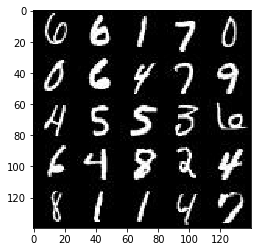

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

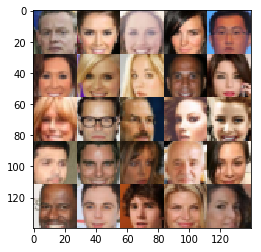

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_in = tf.placeholder(tf.float32, (None,image_width,image_height, image_channels), name= 'real_input')
    z_in = tf.placeholder(tf.float32, (None,z_dim), name = 'z_input')
    learning_rate = tf.placeholder(tf.float32, name= 'learning_rate')
    return real_in, z_in, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'File "/opt/co

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [13]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
  
    #setting alpha to .01; value may have to be changed
    #first try: as in DCGAN example
    with tf.variable_scope('discriminator',reuse=reuse):
        alpha = 0.2
        
        #added truncated_normal_initializer as recommended in review. But no siginificant improvement.
        c1= tf.layers.conv2d(images,64,4,strides=2,padding='same',kernel_initializer=tf.truncated_normal_initializer(stddev=0.02))
        c1 = tf.maximum(alpha *c1, c1)
        #c1 = tf.nn.dropout(c1, keep_prob =0.8)
        # using dropout layers actually caused a much worse overall performance because the discriminator was dominating
        # at the beginning of training 
        #14x14x64
        
        c2 = tf.layers.conv2d(c1,128,4,strides=2, padding='same',kernel_initializer=tf.truncated_normal_initializer(stddev=0.02))
        c2 = tf.layers.batch_normalization(c2,training=True)
        c2 = tf.maximum(alpha*c2, c2)
        #c2 = tf.nn.dropout(c2, keep_prob =0.8)
        #7x7x128
        
        c3 = tf.layers.conv2d(c2,256,4,strides=1, padding='valid',kernel_initializer=tf.truncated_normal_initializer(stddev=0.02))
        c3 = tf.layers.batch_normalization(c3,training=True)
        c3 = tf.maximum(alpha*c3, c3)
        #c3 = tf.nn.dropout(c3, keep_prob =0.8)
        #4x4x256
        
        #c4 = tf.layers.conv2d(c3,512,4,strides=1, padding='same')
        #c4 = tf.layers.batch_normalization(c4,training=True)
        #c4 = tf.maximum(alpha*c4, c4)
        #4x4x512
        
        #c5 = tf.layers.conv2d(c4,1024,2,strides=2,padding='same')
        #c5 = tf.layers.batch_normalization(c5,training=True)
        #c5= tf.maximum(alpha * c5, c5)
        #2*2*1024
        
        flat = tf.reshape(c3,(-1,4*4*512))
        logits = tf.layers.dense(flat,1,activation=None,kernel_initializer=tf.truncated_normal_initializer(stddev=0.02))
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [14]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    # trying an  architecture similar to the DCGAN example
    # again alpha may have to be changed
    with tf.variable_scope('generator',reuse= not is_train):
        alpha = 0.2
        x = tf.layers.dense(z,2*2*1024)
        x = tf.reshape(x,(-1,2,2,1024))
        x = tf.maximum(alpha*x, x)
        x = tf.nn.dropout(x, keep_prob =0.8)
        #2x2x1024
        
        c1 = tf.layers.conv2d_transpose(x,512,5, strides=2, padding='same')
        c1 = tf.layers.batch_normalization(c1,training=is_train)
        c1 = tf.maximum(alpha * c1,c1)
        c1 = tf.nn.dropout(c1, keep_prob =0.8)
        #4x4x512
        
        c2 = tf.layers.conv2d_transpose(c1,256,4, strides=1,padding='valid')
        c2 = tf.layers.batch_normalization(c2,training=is_train)
        c2 = tf.maximum(alpha * c2,c2)
        c2 = tf.nn.dropout(c2, keep_prob =0.8)
        #7x7x256
        
        c3 = tf.layers.conv2d_transpose(c2,128,5, strides=2, padding='same')
        c3 = tf.layers.batch_normalization(c3,training=is_train)
        c3 = tf.maximum(alpha * c3,c3)
        c3 = tf.nn.dropout(c3, keep_prob =0.8)
        #14x14x128
        
        #c4 = tf.layers.conv2d_transpose(c3,32,5, strides=1, padding='same')
        #c4 = tf.layers.batch_normalization(c4,training=is_train)
        #c4 = tf.maximum(alpha * c4,c4)
        #14x14x32

        
        logits = tf.layers.conv2d_transpose(c3,out_channel_dim,5,strides=2,padding = 'same')
        #28x28xout_channel_dim
        # for the output scale the tanh with 0.5 as the pictures being used are in that range
        # in the first review I was told to scale it in the train function but I was not able to detect any 
        # differences in performance between these two variations so I leave as it was
        # (the only possible reason for changing, that I see is reusability of this function)
        output = .5* tf.tanh(logits)
        
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [15]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    smooth = 0.1
    # TODO: Implement Function
    g_model = generator(input_z,out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model,reuse=True)
    
    d_loss_real = tf.reduce_mean(
                tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels= tf.ones_like(d_logits_real)*(1-smooth)))
    d_loss_fake = tf.reduce_mean(
                tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels = tf.zeros_like(d_logits_fake)*(1-smooth)))
    g_loss = tf.reduce_mean(
                tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake, labels = tf.ones_like(d_logits_fake)*(1-smooth)))
    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [16]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    all_vars = tf.trainable_variables()
    d_vars = [var for var in all_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in all_vars if var.name.startswith('generator')]
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_optimizer = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss,var_list = d_vars)
        g_optimizer = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss,var_list = g_vars)
    return d_optimizer, g_optimizer


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [17]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [18]:
import matplotlib.pyplot as plt
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    real_in, z_in, learning_r = model_inputs(data_shape[1],data_shape[2], data_shape[3],z_dim)
    d_loss, g_loss = model_loss(real_in,z_in,data_shape[3])
    d_opt, g_opt = model_opt(d_loss,g_loss,learning_rate, beta1)
    steps = 0
    d_loss_vec=[]
    g_loss_vec=[]
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images = batch_images #No need to rescale it because scaling is done in the generator
                # TODO: Train Model
                steps +=1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                                
                sess.run(d_opt,feed_dict={real_in:batch_images, z_in: batch_z, learning_r:learning_rate})
                sess.run(g_opt,feed_dict={real_in:batch_images, z_in: batch_z, learning_r:learning_rate})
                #sess.run(g_opt,feed_dict={real_in:batch_images, z_in: batch_z, learning_r:learning_rate})
                #the review suggested to run generator optimazation twice but this did not lead to stable, but
                #not really good results (disc-loss around 1.5, gen-loss around 0.7, faces not realistic)
                
                
                
                train_loss_d = sess.run(d_loss, {z_in: batch_z, real_in: batch_images, learning_r:learning_rate})
                train_loss_g = g_loss.eval({z_in: batch_z, learning_r:learning_rate})
                
                d_loss_vec.append(train_loss_d)
                g_loss_vec.append(train_loss_g)
                
                if steps %10 ==0:
                    print("Epoch {}/{}...".format(epoch_i, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                if steps %100 == 0: 
                    show_generator_output(sess,16,z_in,data_shape[3],data_image_mode)
        
        Discriminator_loss, = plt.plot(d_loss_vec, color='b', label='Discriminator loss')
        Genereator_loss, = plt.plot(g_loss_vec, color='r', label='Generator loss')
        plt.legend(handles=[ Discriminator_loss, Genereator_loss])
        #print(d_loss_vec,g_loss_vec)        

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 0/2... Discriminator Loss: 5.7652... Generator Loss: 0.5338
Epoch 0/2... Discriminator Loss: 5.8450... Generator Loss: 7.8183
Epoch 0/2... Discriminator Loss: 2.3390... Generator Loss: 0.3439
Epoch 0/2... Discriminator Loss: 2.0356... Generator Loss: 0.4538
Epoch 0/2... Discriminator Loss: 2.4044... Generator Loss: 0.3901
Epoch 0/2... Discriminator Loss: 1.4605... Generator Loss: 0.5812
Epoch 0/2... Discriminator Loss: 1.9963... Generator Loss: 0.4125
Epoch 0/2... Discriminator Loss: 1.7143... Generator Loss: 0.4945
Epoch 0/2... Discriminator Loss: 1.8812... Generator Loss: 0.4393
Epoch 0/2... Discriminator Loss: 1.3473... Generator Loss: 1.3074


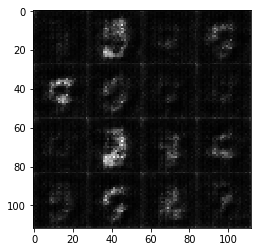

Epoch 0/2... Discriminator Loss: 1.2788... Generator Loss: 1.1003
Epoch 0/2... Discriminator Loss: 1.3351... Generator Loss: 1.7197
Epoch 0/2... Discriminator Loss: 1.3908... Generator Loss: 1.5446
Epoch 0/2... Discriminator Loss: 2.1137... Generator Loss: 1.9568
Epoch 0/2... Discriminator Loss: 1.2458... Generator Loss: 1.4288
Epoch 0/2... Discriminator Loss: 1.4608... Generator Loss: 1.1822
Epoch 0/2... Discriminator Loss: 1.3485... Generator Loss: 0.8653
Epoch 0/2... Discriminator Loss: 1.4688... Generator Loss: 0.5619
Epoch 0/2... Discriminator Loss: 1.4794... Generator Loss: 1.6190
Epoch 0/2... Discriminator Loss: 1.3968... Generator Loss: 1.6518


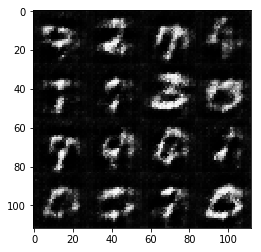

Epoch 0/2... Discriminator Loss: 1.3409... Generator Loss: 1.7058
Epoch 0/2... Discriminator Loss: 1.1189... Generator Loss: 0.7214
Epoch 0/2... Discriminator Loss: 1.3000... Generator Loss: 0.9319
Epoch 0/2... Discriminator Loss: 0.9557... Generator Loss: 1.6339
Epoch 0/2... Discriminator Loss: 1.5685... Generator Loss: 2.0858
Epoch 0/2... Discriminator Loss: 1.8578... Generator Loss: 2.4162
Epoch 0/2... Discriminator Loss: 1.1035... Generator Loss: 1.5283
Epoch 0/2... Discriminator Loss: 1.2874... Generator Loss: 1.1750
Epoch 0/2... Discriminator Loss: 1.4656... Generator Loss: 2.0616
Epoch 0/2... Discriminator Loss: 1.5872... Generator Loss: 2.2438


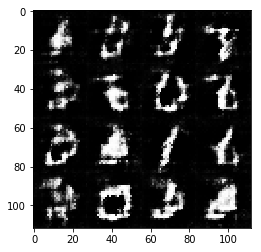

Epoch 0/2... Discriminator Loss: 1.3732... Generator Loss: 1.0790
Epoch 0/2... Discriminator Loss: 1.1932... Generator Loss: 1.0294
Epoch 0/2... Discriminator Loss: 1.3620... Generator Loss: 1.5277
Epoch 0/2... Discriminator Loss: 1.4688... Generator Loss: 1.8794
Epoch 0/2... Discriminator Loss: 1.2840... Generator Loss: 1.3704
Epoch 0/2... Discriminator Loss: 1.3634... Generator Loss: 0.9787
Epoch 0/2... Discriminator Loss: 1.4644... Generator Loss: 0.5756
Epoch 0/2... Discriminator Loss: 1.7326... Generator Loss: 0.4535
Epoch 0/2... Discriminator Loss: 1.7520... Generator Loss: 0.4185
Epoch 0/2... Discriminator Loss: 1.6673... Generator Loss: 0.4535


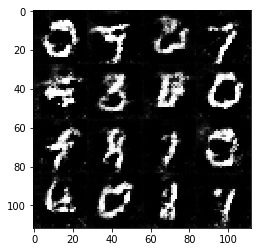

Epoch 0/2... Discriminator Loss: 1.5605... Generator Loss: 0.5016
Epoch 0/2... Discriminator Loss: 1.4924... Generator Loss: 0.5016
Epoch 0/2... Discriminator Loss: 1.6802... Generator Loss: 0.4504
Epoch 0/2... Discriminator Loss: 1.5127... Generator Loss: 0.5879
Epoch 0/2... Discriminator Loss: 1.6417... Generator Loss: 0.4287
Epoch 0/2... Discriminator Loss: 1.2141... Generator Loss: 0.8360
Epoch 0/2... Discriminator Loss: 1.1752... Generator Loss: 1.4054
Epoch 0/2... Discriminator Loss: 1.3612... Generator Loss: 1.9656
Epoch 0/2... Discriminator Loss: 1.7332... Generator Loss: 0.4226
Epoch 0/2... Discriminator Loss: 1.5405... Generator Loss: 0.4725


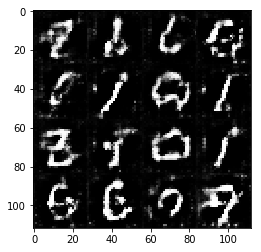

Epoch 0/2... Discriminator Loss: 1.5226... Generator Loss: 1.3021
Epoch 0/2... Discriminator Loss: 1.4827... Generator Loss: 0.5166
Epoch 0/2... Discriminator Loss: 1.5639... Generator Loss: 0.4621
Epoch 0/2... Discriminator Loss: 1.6548... Generator Loss: 0.4537
Epoch 0/2... Discriminator Loss: 1.3307... Generator Loss: 0.5631
Epoch 0/2... Discriminator Loss: 1.6305... Generator Loss: 1.7010
Epoch 0/2... Discriminator Loss: 1.3525... Generator Loss: 1.5753
Epoch 0/2... Discriminator Loss: 1.1355... Generator Loss: 1.8072
Epoch 0/2... Discriminator Loss: 1.4028... Generator Loss: 1.6763
Epoch 0/2... Discriminator Loss: 1.4392... Generator Loss: 1.9876


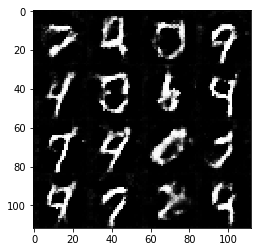

Epoch 0/2... Discriminator Loss: 1.5113... Generator Loss: 1.9502
Epoch 0/2... Discriminator Loss: 1.2155... Generator Loss: 0.6748
Epoch 0/2... Discriminator Loss: 1.1419... Generator Loss: 1.3753
Epoch 0/2... Discriminator Loss: 1.1806... Generator Loss: 1.3344
Epoch 0/2... Discriminator Loss: 1.8394... Generator Loss: 0.4119
Epoch 0/2... Discriminator Loss: 1.0962... Generator Loss: 1.1883
Epoch 0/2... Discriminator Loss: 1.3216... Generator Loss: 1.7096
Epoch 0/2... Discriminator Loss: 1.6558... Generator Loss: 2.0522
Epoch 0/2... Discriminator Loss: 1.7372... Generator Loss: 0.4280
Epoch 0/2... Discriminator Loss: 1.6884... Generator Loss: 0.4241


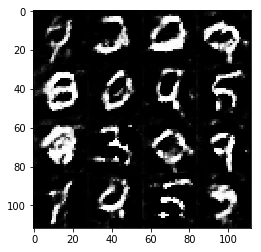

Epoch 0/2... Discriminator Loss: 1.1607... Generator Loss: 0.6579
Epoch 0/2... Discriminator Loss: 0.9712... Generator Loss: 1.0249
Epoch 0/2... Discriminator Loss: 1.6193... Generator Loss: 0.4600
Epoch 0/2... Discriminator Loss: 1.8065... Generator Loss: 0.4335
Epoch 0/2... Discriminator Loss: 1.8114... Generator Loss: 0.4237
Epoch 0/2... Discriminator Loss: 1.1892... Generator Loss: 0.7405
Epoch 0/2... Discriminator Loss: 1.1324... Generator Loss: 0.7109
Epoch 0/2... Discriminator Loss: 0.9660... Generator Loss: 0.9132
Epoch 0/2... Discriminator Loss: 1.0997... Generator Loss: 1.5929
Epoch 0/2... Discriminator Loss: 1.2911... Generator Loss: 1.7181


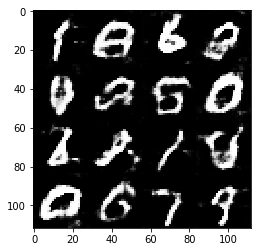

Epoch 0/2... Discriminator Loss: 1.1032... Generator Loss: 0.9181
Epoch 0/2... Discriminator Loss: 1.2769... Generator Loss: 1.8224
Epoch 0/2... Discriminator Loss: 1.5816... Generator Loss: 1.6595
Epoch 0/2... Discriminator Loss: 1.3901... Generator Loss: 1.9649
Epoch 0/2... Discriminator Loss: 1.1720... Generator Loss: 1.1393
Epoch 0/2... Discriminator Loss: 1.3866... Generator Loss: 0.5781
Epoch 0/2... Discriminator Loss: 1.5809... Generator Loss: 0.4651
Epoch 0/2... Discriminator Loss: 1.1170... Generator Loss: 1.7568
Epoch 0/2... Discriminator Loss: 1.6820... Generator Loss: 2.2492
Epoch 0/2... Discriminator Loss: 0.9548... Generator Loss: 1.6625


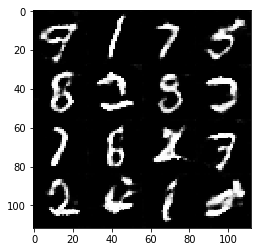

Epoch 0/2... Discriminator Loss: 1.1287... Generator Loss: 0.7541
Epoch 0/2... Discriminator Loss: 1.2235... Generator Loss: 0.7394
Epoch 0/2... Discriminator Loss: 1.3267... Generator Loss: 0.5592
Epoch 0/2... Discriminator Loss: 1.2461... Generator Loss: 0.6590
Epoch 0/2... Discriminator Loss: 0.8844... Generator Loss: 1.0798
Epoch 0/2... Discriminator Loss: 1.0170... Generator Loss: 2.3833
Epoch 0/2... Discriminator Loss: 1.5589... Generator Loss: 0.4996
Epoch 0/2... Discriminator Loss: 1.1699... Generator Loss: 0.7420
Epoch 0/2... Discriminator Loss: 1.3815... Generator Loss: 0.5973
Epoch 0/2... Discriminator Loss: 1.5689... Generator Loss: 0.4678


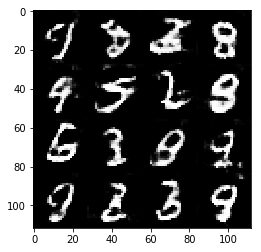

Epoch 0/2... Discriminator Loss: 1.1796... Generator Loss: 0.7222
Epoch 0/2... Discriminator Loss: 0.8216... Generator Loss: 1.1863
Epoch 0/2... Discriminator Loss: 1.2368... Generator Loss: 1.7349
Epoch 0/2... Discriminator Loss: 1.0833... Generator Loss: 1.6234
Epoch 0/2... Discriminator Loss: 1.1473... Generator Loss: 1.6955
Epoch 0/2... Discriminator Loss: 1.0497... Generator Loss: 0.8187
Epoch 0/2... Discriminator Loss: 0.8932... Generator Loss: 1.3487
Epoch 0/2... Discriminator Loss: 1.2937... Generator Loss: 0.6963
Epoch 0/2... Discriminator Loss: 1.2549... Generator Loss: 1.6662
Epoch 0/2... Discriminator Loss: 1.1856... Generator Loss: 0.7034


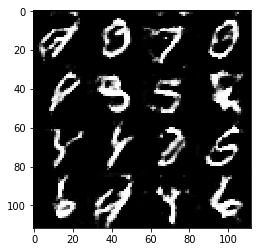

Epoch 0/2... Discriminator Loss: 1.0567... Generator Loss: 1.5822
Epoch 0/2... Discriminator Loss: 1.4075... Generator Loss: 2.2299
Epoch 0/2... Discriminator Loss: 0.9887... Generator Loss: 2.0212
Epoch 0/2... Discriminator Loss: 0.6899... Generator Loss: 1.4179
Epoch 0/2... Discriminator Loss: 1.3914... Generator Loss: 0.6794
Epoch 0/2... Discriminator Loss: 1.3724... Generator Loss: 0.5910
Epoch 0/2... Discriminator Loss: 1.0147... Generator Loss: 0.9102
Epoch 0/2... Discriminator Loss: 0.9404... Generator Loss: 1.3032
Epoch 0/2... Discriminator Loss: 2.4344... Generator Loss: 3.3111
Epoch 0/2... Discriminator Loss: 1.0552... Generator Loss: 1.9661


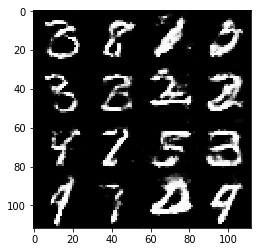

Epoch 0/2... Discriminator Loss: 0.9918... Generator Loss: 1.0157
Epoch 0/2... Discriminator Loss: 0.8760... Generator Loss: 1.3249
Epoch 0/2... Discriminator Loss: 0.9092... Generator Loss: 0.8883
Epoch 0/2... Discriminator Loss: 1.0068... Generator Loss: 0.7839
Epoch 0/2... Discriminator Loss: 1.4852... Generator Loss: 2.6413
Epoch 0/2... Discriminator Loss: 0.9863... Generator Loss: 1.4857
Epoch 0/2... Discriminator Loss: 1.1043... Generator Loss: 2.4194
Epoch 0/2... Discriminator Loss: 1.1589... Generator Loss: 2.1595
Epoch 0/2... Discriminator Loss: 1.6966... Generator Loss: 0.5188
Epoch 0/2... Discriminator Loss: 0.9044... Generator Loss: 1.0487


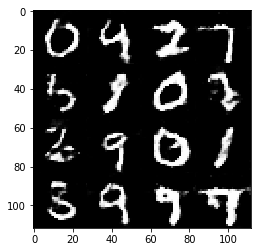

Epoch 0/2... Discriminator Loss: 0.9263... Generator Loss: 0.8162
Epoch 0/2... Discriminator Loss: 1.3999... Generator Loss: 0.6420
Epoch 0/2... Discriminator Loss: 1.4435... Generator Loss: 0.6650
Epoch 0/2... Discriminator Loss: 1.7400... Generator Loss: 3.2713
Epoch 0/2... Discriminator Loss: 1.0709... Generator Loss: 1.4628
Epoch 0/2... Discriminator Loss: 1.1806... Generator Loss: 0.7514
Epoch 0/2... Discriminator Loss: 0.9226... Generator Loss: 2.5694
Epoch 0/2... Discriminator Loss: 0.9641... Generator Loss: 1.3160
Epoch 0/2... Discriminator Loss: 0.9669... Generator Loss: 0.9256
Epoch 0/2... Discriminator Loss: 1.4432... Generator Loss: 0.5907


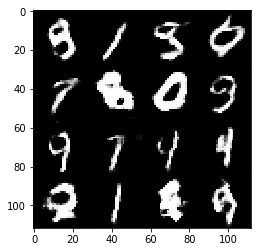

Epoch 0/2... Discriminator Loss: 1.6713... Generator Loss: 0.5133
Epoch 0/2... Discriminator Loss: 0.7208... Generator Loss: 1.3964
Epoch 0/2... Discriminator Loss: 1.0933... Generator Loss: 2.0848
Epoch 0/2... Discriminator Loss: 0.9678... Generator Loss: 1.5219
Epoch 0/2... Discriminator Loss: 1.2004... Generator Loss: 2.4318
Epoch 0/2... Discriminator Loss: 1.7012... Generator Loss: 0.4195
Epoch 0/2... Discriminator Loss: 0.7913... Generator Loss: 1.0195
Epoch 0/2... Discriminator Loss: 1.4203... Generator Loss: 0.5744
Epoch 0/2... Discriminator Loss: 1.3858... Generator Loss: 0.5651
Epoch 0/2... Discriminator Loss: 1.1567... Generator Loss: 0.6966


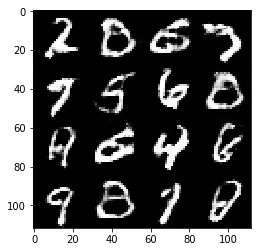

Epoch 0/2... Discriminator Loss: 1.7323... Generator Loss: 0.5714
Epoch 0/2... Discriminator Loss: 1.4521... Generator Loss: 0.6021
Epoch 0/2... Discriminator Loss: 0.9570... Generator Loss: 2.5827
Epoch 0/2... Discriminator Loss: 0.6647... Generator Loss: 1.2785
Epoch 0/2... Discriminator Loss: 1.1164... Generator Loss: 2.7863
Epoch 0/2... Discriminator Loss: 0.8660... Generator Loss: 1.1049
Epoch 0/2... Discriminator Loss: 1.1108... Generator Loss: 0.7935
Epoch 0/2... Discriminator Loss: 1.2497... Generator Loss: 0.7592
Epoch 0/2... Discriminator Loss: 0.9631... Generator Loss: 1.8545
Epoch 0/2... Discriminator Loss: 0.6236... Generator Loss: 2.1091


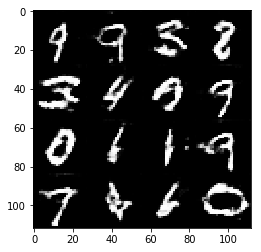

Epoch 0/2... Discriminator Loss: 1.7478... Generator Loss: 0.5061
Epoch 0/2... Discriminator Loss: 1.2908... Generator Loss: 0.6270
Epoch 0/2... Discriminator Loss: 1.1324... Generator Loss: 0.7105
Epoch 0/2... Discriminator Loss: 0.8469... Generator Loss: 1.0570
Epoch 0/2... Discriminator Loss: 0.8530... Generator Loss: 0.9424
Epoch 0/2... Discriminator Loss: 0.6460... Generator Loss: 1.5309
Epoch 0/2... Discriminator Loss: 1.2929... Generator Loss: 0.6313
Epoch 0/2... Discriminator Loss: 0.7859... Generator Loss: 1.9364
Epoch 0/2... Discriminator Loss: 1.5274... Generator Loss: 0.5109
Epoch 0/2... Discriminator Loss: 0.8698... Generator Loss: 0.9285


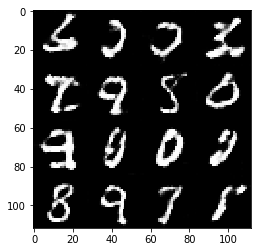

Epoch 0/2... Discriminator Loss: 1.1922... Generator Loss: 0.7201
Epoch 0/2... Discriminator Loss: 1.1321... Generator Loss: 0.7319
Epoch 0/2... Discriminator Loss: 1.2926... Generator Loss: 3.1361
Epoch 0/2... Discriminator Loss: 0.6608... Generator Loss: 1.4918
Epoch 0/2... Discriminator Loss: 1.1264... Generator Loss: 2.1549
Epoch 0/2... Discriminator Loss: 0.8111... Generator Loss: 1.9327
Epoch 0/2... Discriminator Loss: 0.7167... Generator Loss: 1.6028
Epoch 0/2... Discriminator Loss: 0.7034... Generator Loss: 1.2782
Epoch 0/2... Discriminator Loss: 0.6481... Generator Loss: 1.4155
Epoch 0/2... Discriminator Loss: 0.6935... Generator Loss: 1.3903


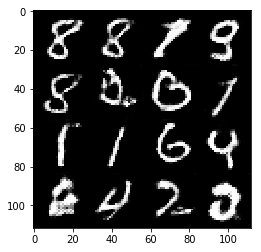

Epoch 0/2... Discriminator Loss: 1.3589... Generator Loss: 0.7351
Epoch 0/2... Discriminator Loss: 0.5787... Generator Loss: 2.3040
Epoch 0/2... Discriminator Loss: 0.6715... Generator Loss: 1.4590
Epoch 0/2... Discriminator Loss: 1.8430... Generator Loss: 0.4801
Epoch 0/2... Discriminator Loss: 0.9885... Generator Loss: 1.0228
Epoch 0/2... Discriminator Loss: 0.7609... Generator Loss: 1.6003
Epoch 0/2... Discriminator Loss: 1.3795... Generator Loss: 0.5449
Epoch 1/2... Discriminator Loss: 0.8024... Generator Loss: 0.9566
Epoch 1/2... Discriminator Loss: 1.5802... Generator Loss: 0.5034
Epoch 1/2... Discriminator Loss: 1.2176... Generator Loss: 3.1373


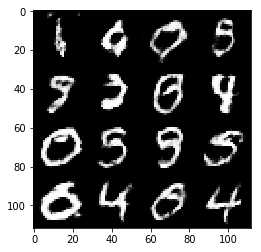

Epoch 1/2... Discriminator Loss: 0.6667... Generator Loss: 1.5329
Epoch 1/2... Discriminator Loss: 1.2946... Generator Loss: 2.9892
Epoch 1/2... Discriminator Loss: 1.2526... Generator Loss: 2.1698
Epoch 1/2... Discriminator Loss: 0.7840... Generator Loss: 1.5081
Epoch 1/2... Discriminator Loss: 1.1761... Generator Loss: 2.6790
Epoch 1/2... Discriminator Loss: 0.5987... Generator Loss: 2.4801
Epoch 1/2... Discriminator Loss: 0.6278... Generator Loss: 1.7470
Epoch 1/2... Discriminator Loss: 0.5973... Generator Loss: 1.8340
Epoch 1/2... Discriminator Loss: 0.9473... Generator Loss: 0.9070
Epoch 1/2... Discriminator Loss: 0.6762... Generator Loss: 2.8369


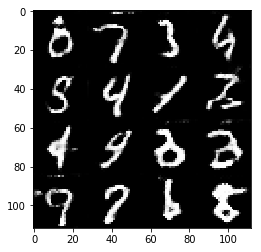

Epoch 1/2... Discriminator Loss: 2.2787... Generator Loss: 0.4037
Epoch 1/2... Discriminator Loss: 1.0325... Generator Loss: 0.8190
Epoch 1/2... Discriminator Loss: 1.3474... Generator Loss: 3.5968
Epoch 1/2... Discriminator Loss: 0.6840... Generator Loss: 1.1582
Epoch 1/2... Discriminator Loss: 0.7286... Generator Loss: 1.2299
Epoch 1/2... Discriminator Loss: 1.5107... Generator Loss: 0.6408
Epoch 1/2... Discriminator Loss: 1.0678... Generator Loss: 0.9769
Epoch 1/2... Discriminator Loss: 0.5107... Generator Loss: 1.7086
Epoch 1/2... Discriminator Loss: 2.0449... Generator Loss: 4.4078
Epoch 1/2... Discriminator Loss: 0.9087... Generator Loss: 2.4650


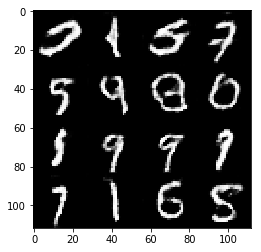

Epoch 1/2... Discriminator Loss: 0.5226... Generator Loss: 1.9665
Epoch 1/2... Discriminator Loss: 0.4626... Generator Loss: 2.1238
Epoch 1/2... Discriminator Loss: 1.2723... Generator Loss: 3.0379
Epoch 1/2... Discriminator Loss: 0.6331... Generator Loss: 1.6665
Epoch 1/2... Discriminator Loss: 0.5600... Generator Loss: 1.4734
Epoch 1/2... Discriminator Loss: 1.0726... Generator Loss: 0.8685
Epoch 1/2... Discriminator Loss: 0.6566... Generator Loss: 1.6488
Epoch 1/2... Discriminator Loss: 0.7625... Generator Loss: 2.5272
Epoch 1/2... Discriminator Loss: 0.5198... Generator Loss: 2.0706
Epoch 1/2... Discriminator Loss: 1.4585... Generator Loss: 0.6234


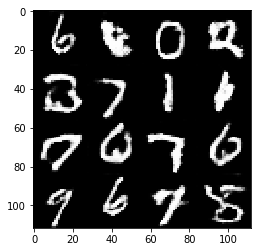

Epoch 1/2... Discriminator Loss: 0.6157... Generator Loss: 1.3901
Epoch 1/2... Discriminator Loss: 0.5274... Generator Loss: 1.7544
Epoch 1/2... Discriminator Loss: 0.7931... Generator Loss: 1.0977
Epoch 1/2... Discriminator Loss: 1.8316... Generator Loss: 0.4842
Epoch 1/2... Discriminator Loss: 1.1392... Generator Loss: 2.9704
Epoch 1/2... Discriminator Loss: 0.5123... Generator Loss: 2.2104
Epoch 1/2... Discriminator Loss: 0.5203... Generator Loss: 1.9905
Epoch 1/2... Discriminator Loss: 0.7246... Generator Loss: 1.2003
Epoch 1/2... Discriminator Loss: 1.2727... Generator Loss: 0.6596
Epoch 1/2... Discriminator Loss: 1.6449... Generator Loss: 0.5739


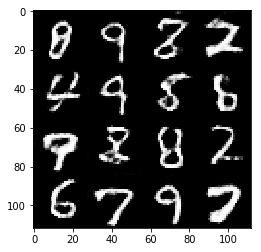

Epoch 1/2... Discriminator Loss: 0.5832... Generator Loss: 1.8324
Epoch 1/2... Discriminator Loss: 1.2640... Generator Loss: 0.6941
Epoch 1/2... Discriminator Loss: 0.7279... Generator Loss: 1.2241
Epoch 1/2... Discriminator Loss: 0.5421... Generator Loss: 1.8227
Epoch 1/2... Discriminator Loss: 1.5513... Generator Loss: 0.6872
Epoch 1/2... Discriminator Loss: 1.1988... Generator Loss: 0.8633
Epoch 1/2... Discriminator Loss: 0.5537... Generator Loss: 2.0755
Epoch 1/2... Discriminator Loss: 1.0018... Generator Loss: 3.1772
Epoch 1/2... Discriminator Loss: 0.7185... Generator Loss: 2.2179
Epoch 1/2... Discriminator Loss: 0.5816... Generator Loss: 2.4159


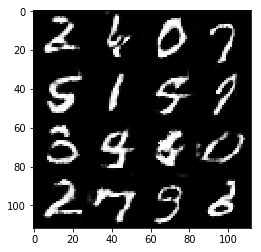

Epoch 1/2... Discriminator Loss: 1.0443... Generator Loss: 1.1130
Epoch 1/2... Discriminator Loss: 1.7680... Generator Loss: 0.5636
Epoch 1/2... Discriminator Loss: 0.6510... Generator Loss: 1.5750
Epoch 1/2... Discriminator Loss: 0.8698... Generator Loss: 1.3817
Epoch 1/2... Discriminator Loss: 0.6444... Generator Loss: 2.7241
Epoch 1/2... Discriminator Loss: 0.6190... Generator Loss: 1.7448
Epoch 1/2... Discriminator Loss: 1.1700... Generator Loss: 1.0184
Epoch 1/2... Discriminator Loss: 0.9813... Generator Loss: 0.9550
Epoch 1/2... Discriminator Loss: 1.3357... Generator Loss: 0.7290
Epoch 1/2... Discriminator Loss: 0.5860... Generator Loss: 1.7792


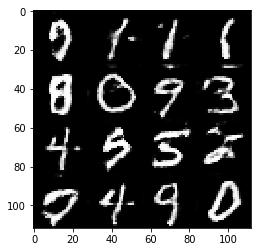

Epoch 1/2... Discriminator Loss: 0.6519... Generator Loss: 3.0637
Epoch 1/2... Discriminator Loss: 0.6797... Generator Loss: 2.9053
Epoch 1/2... Discriminator Loss: 0.9352... Generator Loss: 1.1102
Epoch 1/2... Discriminator Loss: 0.7141... Generator Loss: 1.2937
Epoch 1/2... Discriminator Loss: 1.9280... Generator Loss: 0.5215
Epoch 1/2... Discriminator Loss: 0.9073... Generator Loss: 1.0529
Epoch 1/2... Discriminator Loss: 1.0498... Generator Loss: 0.8705
Epoch 1/2... Discriminator Loss: 0.7420... Generator Loss: 1.3333
Epoch 1/2... Discriminator Loss: 0.7544... Generator Loss: 1.2903
Epoch 1/2... Discriminator Loss: 0.5684... Generator Loss: 1.3825


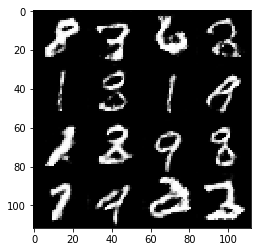

Epoch 1/2... Discriminator Loss: 0.8301... Generator Loss: 1.2030
Epoch 1/2... Discriminator Loss: 0.6185... Generator Loss: 2.9768
Epoch 1/2... Discriminator Loss: 0.7601... Generator Loss: 1.4822
Epoch 1/2... Discriminator Loss: 1.1618... Generator Loss: 0.7213
Epoch 1/2... Discriminator Loss: 2.2906... Generator Loss: 0.4075
Epoch 1/2... Discriminator Loss: 0.6612... Generator Loss: 1.4481
Epoch 1/2... Discriminator Loss: 0.5638... Generator Loss: 1.7415
Epoch 1/2... Discriminator Loss: 0.9691... Generator Loss: 3.4649
Epoch 1/2... Discriminator Loss: 0.7946... Generator Loss: 3.7787
Epoch 1/2... Discriminator Loss: 0.9181... Generator Loss: 1.2592


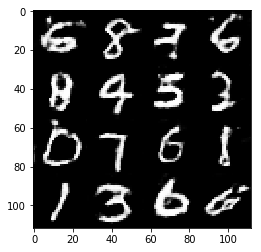

Epoch 1/2... Discriminator Loss: 0.5740... Generator Loss: 1.9193
Epoch 1/2... Discriminator Loss: 1.1451... Generator Loss: 0.7849
Epoch 1/2... Discriminator Loss: 0.5449... Generator Loss: 3.0539
Epoch 1/2... Discriminator Loss: 0.7112... Generator Loss: 2.6750
Epoch 1/2... Discriminator Loss: 1.6202... Generator Loss: 0.7651
Epoch 1/2... Discriminator Loss: 1.2348... Generator Loss: 0.8428
Epoch 1/2... Discriminator Loss: 0.4400... Generator Loss: 2.6695
Epoch 1/2... Discriminator Loss: 0.7933... Generator Loss: 1.1183
Epoch 1/2... Discriminator Loss: 1.0894... Generator Loss: 0.8428
Epoch 1/2... Discriminator Loss: 0.9857... Generator Loss: 1.0393


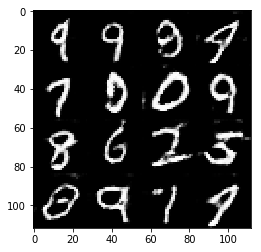

Epoch 1/2... Discriminator Loss: 0.6721... Generator Loss: 1.6791
Epoch 1/2... Discriminator Loss: 0.5103... Generator Loss: 2.6626
Epoch 1/2... Discriminator Loss: 0.8108... Generator Loss: 1.2906
Epoch 1/2... Discriminator Loss: 0.4779... Generator Loss: 2.5937
Epoch 1/2... Discriminator Loss: 1.2027... Generator Loss: 0.8383
Epoch 1/2... Discriminator Loss: 1.7335... Generator Loss: 0.4415
Epoch 1/2... Discriminator Loss: 0.9301... Generator Loss: 3.4324
Epoch 1/2... Discriminator Loss: 1.0348... Generator Loss: 1.1127
Epoch 1/2... Discriminator Loss: 0.7234... Generator Loss: 2.5635
Epoch 1/2... Discriminator Loss: 0.5140... Generator Loss: 2.1025


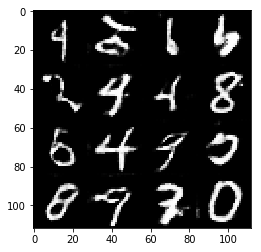

Epoch 1/2... Discriminator Loss: 0.5049... Generator Loss: 2.1164
Epoch 1/2... Discriminator Loss: 0.7391... Generator Loss: 3.0593
Epoch 1/2... Discriminator Loss: 1.9020... Generator Loss: 5.1138
Epoch 1/2... Discriminator Loss: 0.9395... Generator Loss: 1.1311
Epoch 1/2... Discriminator Loss: 0.7456... Generator Loss: 1.4733
Epoch 1/2... Discriminator Loss: 0.7979... Generator Loss: 1.2301
Epoch 1/2... Discriminator Loss: 0.5835... Generator Loss: 2.5185
Epoch 1/2... Discriminator Loss: 0.7608... Generator Loss: 1.2761
Epoch 1/2... Discriminator Loss: 0.7375... Generator Loss: 1.2047
Epoch 1/2... Discriminator Loss: 0.7670... Generator Loss: 3.4799


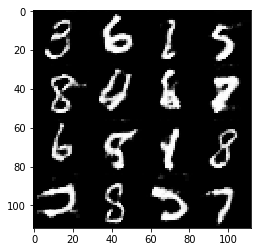

Epoch 1/2... Discriminator Loss: 1.0315... Generator Loss: 0.7166
Epoch 1/2... Discriminator Loss: 0.6963... Generator Loss: 1.7692
Epoch 1/2... Discriminator Loss: 0.4623... Generator Loss: 1.8649
Epoch 1/2... Discriminator Loss: 0.6676... Generator Loss: 1.2992
Epoch 1/2... Discriminator Loss: 1.8168... Generator Loss: 0.6863
Epoch 1/2... Discriminator Loss: 0.7379... Generator Loss: 1.3167
Epoch 1/2... Discriminator Loss: 0.5419... Generator Loss: 1.6898
Epoch 1/2... Discriminator Loss: 0.8345... Generator Loss: 1.3736
Epoch 1/2... Discriminator Loss: 0.5668... Generator Loss: 1.7221
Epoch 1/2... Discriminator Loss: 0.5282... Generator Loss: 1.9074


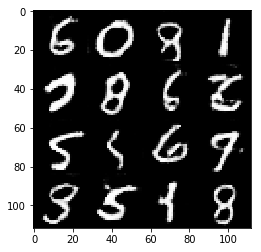

Epoch 1/2... Discriminator Loss: 0.5585... Generator Loss: 1.8558
Epoch 1/2... Discriminator Loss: 0.6164... Generator Loss: 3.0145
Epoch 1/2... Discriminator Loss: 0.8688... Generator Loss: 1.0605
Epoch 1/2... Discriminator Loss: 0.5658... Generator Loss: 1.7933
Epoch 1/2... Discriminator Loss: 0.5198... Generator Loss: 2.2301
Epoch 1/2... Discriminator Loss: 0.6458... Generator Loss: 2.7391
Epoch 1/2... Discriminator Loss: 0.7531... Generator Loss: 1.2046
Epoch 1/2... Discriminator Loss: 0.5933... Generator Loss: 1.8724
Epoch 1/2... Discriminator Loss: 0.5995... Generator Loss: 2.5984
Epoch 1/2... Discriminator Loss: 0.5015... Generator Loss: 2.3152


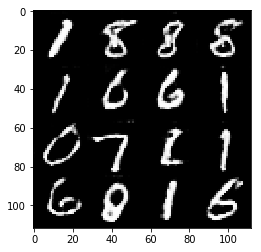

Epoch 1/2... Discriminator Loss: 0.9469... Generator Loss: 1.1169
Epoch 1/2... Discriminator Loss: 2.3951... Generator Loss: 0.4858
Epoch 1/2... Discriminator Loss: 0.6012... Generator Loss: 3.0664
Epoch 1/2... Discriminator Loss: 0.9691... Generator Loss: 0.9234
Epoch 1/2... Discriminator Loss: 0.5979... Generator Loss: 1.8765
Epoch 1/2... Discriminator Loss: 0.4859... Generator Loss: 1.9485
Epoch 1/2... Discriminator Loss: 0.8589... Generator Loss: 1.4636
Epoch 1/2... Discriminator Loss: 0.4594... Generator Loss: 2.2230
Epoch 1/2... Discriminator Loss: 0.6976... Generator Loss: 1.6218
Epoch 1/2... Discriminator Loss: 0.7831... Generator Loss: 1.1207


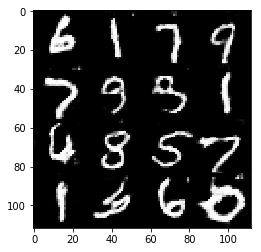

Epoch 1/2... Discriminator Loss: 1.3021... Generator Loss: 0.8106
Epoch 1/2... Discriminator Loss: 0.4937... Generator Loss: 2.0623
Epoch 1/2... Discriminator Loss: 1.4426... Generator Loss: 0.7504
Epoch 1/2... Discriminator Loss: 1.1666... Generator Loss: 0.7452
Epoch 1/2... Discriminator Loss: 0.5056... Generator Loss: 2.0074
Epoch 1/2... Discriminator Loss: 0.4976... Generator Loss: 1.9761
Epoch 1/2... Discriminator Loss: 1.0505... Generator Loss: 0.9560
Epoch 1/2... Discriminator Loss: 1.2443... Generator Loss: 0.9621
Epoch 1/2... Discriminator Loss: 0.5190... Generator Loss: 1.6992
Epoch 1/2... Discriminator Loss: 1.4573... Generator Loss: 4.5063


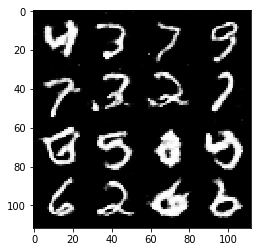

Epoch 1/2... Discriminator Loss: 0.5978... Generator Loss: 1.5059
Epoch 1/2... Discriminator Loss: 0.7747... Generator Loss: 1.1811
Epoch 1/2... Discriminator Loss: 0.4909... Generator Loss: 2.0444
Epoch 1/2... Discriminator Loss: 0.4508... Generator Loss: 2.3153
Epoch 1/2... Discriminator Loss: 0.4959... Generator Loss: 1.8791
Epoch 1/2... Discriminator Loss: 0.6676... Generator Loss: 1.4489
Epoch 1/2... Discriminator Loss: 0.3989... Generator Loss: 2.9567
Epoch 1/2... Discriminator Loss: 1.9471... Generator Loss: 0.6311
Epoch 1/2... Discriminator Loss: 0.5261... Generator Loss: 2.8226
Epoch 1/2... Discriminator Loss: 0.4956... Generator Loss: 2.1326


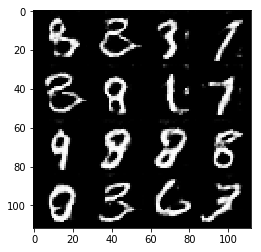

Epoch 1/2... Discriminator Loss: 1.5073... Generator Loss: 4.6125
Epoch 1/2... Discriminator Loss: 0.6592... Generator Loss: 1.4638
Epoch 1/2... Discriminator Loss: 0.6630... Generator Loss: 1.6399
Epoch 1/2... Discriminator Loss: 0.6887... Generator Loss: 1.4376
Epoch 1/2... Discriminator Loss: 0.4220... Generator Loss: 2.4674
Epoch 1/2... Discriminator Loss: 0.5130... Generator Loss: 1.7618
Epoch 1/2... Discriminator Loss: 0.5436... Generator Loss: 2.1775
Epoch 1/2... Discriminator Loss: 0.4531... Generator Loss: 2.5702
Epoch 1/2... Discriminator Loss: 0.4689... Generator Loss: 2.1169
Epoch 1/2... Discriminator Loss: 0.7128... Generator Loss: 3.2920


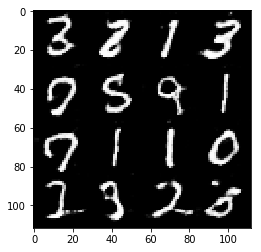

Epoch 1/2... Discriminator Loss: 1.0969... Generator Loss: 1.1759
Epoch 1/2... Discriminator Loss: 0.5250... Generator Loss: 2.7675
Epoch 1/2... Discriminator Loss: 0.4980... Generator Loss: 1.7979
Epoch 1/2... Discriminator Loss: 0.4140... Generator Loss: 2.9126
Epoch 1/2... Discriminator Loss: 0.4447... Generator Loss: 2.1474
Epoch 1/2... Discriminator Loss: 1.3901... Generator Loss: 5.5312
Epoch 1/2... Discriminator Loss: 0.4589... Generator Loss: 2.6667
Epoch 1/2... Discriminator Loss: 0.5952... Generator Loss: 2.0829
Epoch 1/2... Discriminator Loss: 0.4170... Generator Loss: 2.1938
Epoch 1/2... Discriminator Loss: 0.7110... Generator Loss: 1.6453


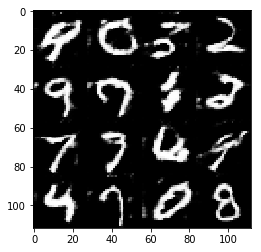

Epoch 1/2... Discriminator Loss: 0.7380... Generator Loss: 3.2878
Epoch 1/2... Discriminator Loss: 0.5571... Generator Loss: 2.0421
Epoch 1/2... Discriminator Loss: 0.5763... Generator Loss: 1.6936
Epoch 1/2... Discriminator Loss: 0.5228... Generator Loss: 2.5224
Epoch 1/2... Discriminator Loss: 0.7471... Generator Loss: 1.0625


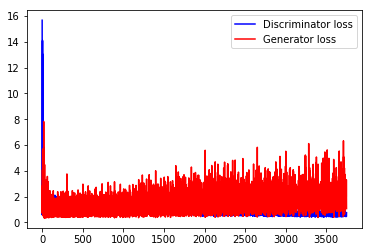

In [20]:
batch_size = 32
z_dim = 10
learning_rate = 0.0008
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0/1... Discriminator Loss: 2.1132... Generator Loss: 0.4345
Epoch 0/1... Discriminator Loss: 0.9619... Generator Loss: 1.0139
Epoch 0/1... Discriminator Loss: 0.7651... Generator Loss: 2.5989
Epoch 0/1... Discriminator Loss: 1.5046... Generator Loss: 0.6050
Epoch 0/1... Discriminator Loss: 1.2699... Generator Loss: 0.6122
Epoch 0/1... Discriminator Loss: 1.4793... Generator Loss: 0.4870
Epoch 0/1... Discriminator Loss: 0.6765... Generator Loss: 3.3838
Epoch 0/1... Discriminator Loss: 0.5367... Generator Loss: 2.3614
Epoch 0/1... Discriminator Loss: 0.5722... Generator Loss: 3.5410
Epoch 0/1... Discriminator Loss: 0.5929... Generator Loss: 1.9179


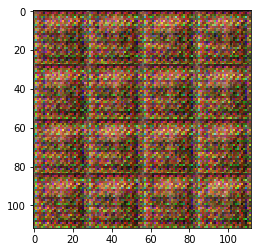

Epoch 0/1... Discriminator Loss: 0.6612... Generator Loss: 1.3956
Epoch 0/1... Discriminator Loss: 0.5273... Generator Loss: 1.8454
Epoch 0/1... Discriminator Loss: 0.5085... Generator Loss: 2.0285
Epoch 0/1... Discriminator Loss: 0.5642... Generator Loss: 2.0006
Epoch 0/1... Discriminator Loss: 0.4290... Generator Loss: 2.8691
Epoch 0/1... Discriminator Loss: 0.9077... Generator Loss: 0.8376
Epoch 0/1... Discriminator Loss: 0.5185... Generator Loss: 2.1063
Epoch 0/1... Discriminator Loss: 0.5316... Generator Loss: 3.6080
Epoch 0/1... Discriminator Loss: 3.1252... Generator Loss: 11.2202
Epoch 0/1... Discriminator Loss: 0.5105... Generator Loss: 1.7126


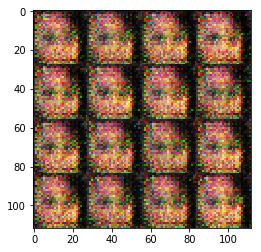

Epoch 0/1... Discriminator Loss: 0.4544... Generator Loss: 2.2568
Epoch 0/1... Discriminator Loss: 0.4550... Generator Loss: 3.3034
Epoch 0/1... Discriminator Loss: 0.6803... Generator Loss: 1.1662
Epoch 0/1... Discriminator Loss: 0.4188... Generator Loss: 3.4409
Epoch 0/1... Discriminator Loss: 0.4025... Generator Loss: 3.3263
Epoch 0/1... Discriminator Loss: 0.4605... Generator Loss: 2.0010
Epoch 0/1... Discriminator Loss: 0.4098... Generator Loss: 3.0986
Epoch 0/1... Discriminator Loss: 0.4313... Generator Loss: 2.3724
Epoch 0/1... Discriminator Loss: 0.4239... Generator Loss: 2.9683
Epoch 0/1... Discriminator Loss: 0.3973... Generator Loss: 3.0552


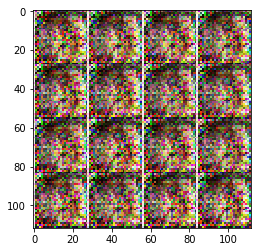

Epoch 0/1... Discriminator Loss: 0.4024... Generator Loss: 2.9189
Epoch 0/1... Discriminator Loss: 0.4526... Generator Loss: 2.2967
Epoch 0/1... Discriminator Loss: 1.0109... Generator Loss: 0.7732
Epoch 0/1... Discriminator Loss: 0.7623... Generator Loss: 1.1663
Epoch 0/1... Discriminator Loss: 0.4313... Generator Loss: 2.6269
Epoch 0/1... Discriminator Loss: 0.4395... Generator Loss: 2.6043
Epoch 0/1... Discriminator Loss: 0.5041... Generator Loss: 2.3762
Epoch 0/1... Discriminator Loss: 1.0722... Generator Loss: 3.7566
Epoch 0/1... Discriminator Loss: 1.0219... Generator Loss: 4.1904
Epoch 0/1... Discriminator Loss: 1.6453... Generator Loss: 0.5021


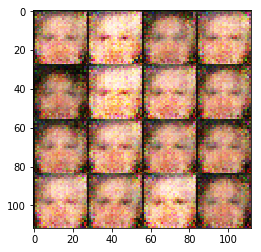

Epoch 0/1... Discriminator Loss: 0.6305... Generator Loss: 1.6623
Epoch 0/1... Discriminator Loss: 1.4177... Generator Loss: 4.3829
Epoch 0/1... Discriminator Loss: 1.2006... Generator Loss: 0.6076
Epoch 0/1... Discriminator Loss: 0.8428... Generator Loss: 1.0178
Epoch 0/1... Discriminator Loss: 1.9563... Generator Loss: 0.4965
Epoch 0/1... Discriminator Loss: 0.9098... Generator Loss: 2.7307
Epoch 0/1... Discriminator Loss: 0.9449... Generator Loss: 3.9530
Epoch 0/1... Discriminator Loss: 2.7736... Generator Loss: 0.3898
Epoch 0/1... Discriminator Loss: 1.0034... Generator Loss: 0.8645
Epoch 0/1... Discriminator Loss: 0.9407... Generator Loss: 2.0311


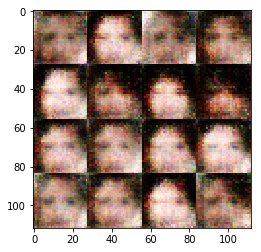

Epoch 0/1... Discriminator Loss: 1.2527... Generator Loss: 2.1495
Epoch 0/1... Discriminator Loss: 2.6049... Generator Loss: 4.7610
Epoch 0/1... Discriminator Loss: 2.1486... Generator Loss: 0.3858
Epoch 0/1... Discriminator Loss: 1.5582... Generator Loss: 3.6265
Epoch 0/1... Discriminator Loss: 0.6764... Generator Loss: 1.8936
Epoch 0/1... Discriminator Loss: 1.4499... Generator Loss: 2.3082
Epoch 0/1... Discriminator Loss: 1.5388... Generator Loss: 0.4809
Epoch 0/1... Discriminator Loss: 1.2557... Generator Loss: 2.8953
Epoch 0/1... Discriminator Loss: 0.9011... Generator Loss: 2.1634
Epoch 0/1... Discriminator Loss: 1.1825... Generator Loss: 0.7047


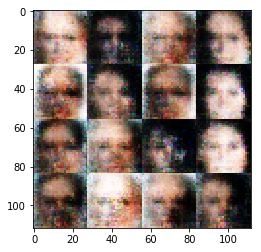

Epoch 0/1... Discriminator Loss: 0.6576... Generator Loss: 1.8797
Epoch 0/1... Discriminator Loss: 1.0784... Generator Loss: 1.9915
Epoch 0/1... Discriminator Loss: 1.0602... Generator Loss: 0.8740
Epoch 0/1... Discriminator Loss: 1.3436... Generator Loss: 2.9118
Epoch 0/1... Discriminator Loss: 1.2378... Generator Loss: 0.6606
Epoch 0/1... Discriminator Loss: 0.7318... Generator Loss: 2.0478
Epoch 0/1... Discriminator Loss: 1.7337... Generator Loss: 0.5143
Epoch 0/1... Discriminator Loss: 1.7486... Generator Loss: 0.4507
Epoch 0/1... Discriminator Loss: 0.7452... Generator Loss: 1.1938
Epoch 0/1... Discriminator Loss: 0.7172... Generator Loss: 1.2673


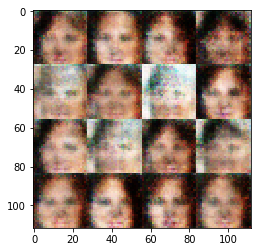

Epoch 0/1... Discriminator Loss: 1.0162... Generator Loss: 0.7961
Epoch 0/1... Discriminator Loss: 0.6552... Generator Loss: 1.5507
Epoch 0/1... Discriminator Loss: 0.8789... Generator Loss: 1.6036
Epoch 0/1... Discriminator Loss: 0.8837... Generator Loss: 2.4172
Epoch 0/1... Discriminator Loss: 1.3946... Generator Loss: 0.5673
Epoch 0/1... Discriminator Loss: 0.7190... Generator Loss: 1.4012
Epoch 0/1... Discriminator Loss: 0.9032... Generator Loss: 1.6209
Epoch 0/1... Discriminator Loss: 1.4783... Generator Loss: 0.6935
Epoch 0/1... Discriminator Loss: 0.6981... Generator Loss: 1.8025
Epoch 0/1... Discriminator Loss: 1.1030... Generator Loss: 0.7546


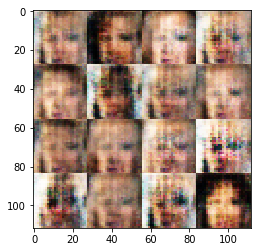

Epoch 0/1... Discriminator Loss: 1.1341... Generator Loss: 2.4882
Epoch 0/1... Discriminator Loss: 1.2654... Generator Loss: 0.6616
Epoch 0/1... Discriminator Loss: 0.9429... Generator Loss: 1.0835
Epoch 0/1... Discriminator Loss: 0.8867... Generator Loss: 1.3769
Epoch 0/1... Discriminator Loss: 0.7580... Generator Loss: 1.5364
Epoch 0/1... Discriminator Loss: 1.0431... Generator Loss: 0.9689
Epoch 0/1... Discriminator Loss: 0.8048... Generator Loss: 1.4288
Epoch 0/1... Discriminator Loss: 0.7328... Generator Loss: 1.7857
Epoch 0/1... Discriminator Loss: 0.8763... Generator Loss: 1.2181
Epoch 0/1... Discriminator Loss: 0.9980... Generator Loss: 2.0293


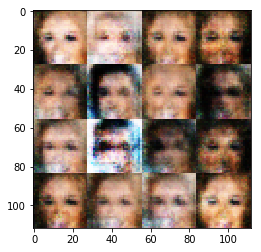

Epoch 0/1... Discriminator Loss: 1.0070... Generator Loss: 0.8203
Epoch 0/1... Discriminator Loss: 1.8397... Generator Loss: 0.4103
Epoch 0/1... Discriminator Loss: 0.9557... Generator Loss: 1.2638
Epoch 0/1... Discriminator Loss: 0.6944... Generator Loss: 1.4703
Epoch 0/1... Discriminator Loss: 0.8732... Generator Loss: 1.7357
Epoch 0/1... Discriminator Loss: 0.9379... Generator Loss: 0.8904
Epoch 0/1... Discriminator Loss: 0.9610... Generator Loss: 1.0136
Epoch 0/1... Discriminator Loss: 0.8561... Generator Loss: 1.8839
Epoch 0/1... Discriminator Loss: 1.5378... Generator Loss: 0.5141
Epoch 0/1... Discriminator Loss: 1.8598... Generator Loss: 0.4148


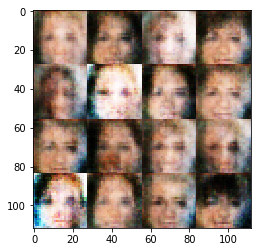

Epoch 0/1... Discriminator Loss: 1.1151... Generator Loss: 1.2545
Epoch 0/1... Discriminator Loss: 0.9352... Generator Loss: 1.0261
Epoch 0/1... Discriminator Loss: 0.9243... Generator Loss: 0.9026
Epoch 0/1... Discriminator Loss: 0.9403... Generator Loss: 0.9877
Epoch 0/1... Discriminator Loss: 1.1948... Generator Loss: 2.4728
Epoch 0/1... Discriminator Loss: 1.0423... Generator Loss: 0.8726
Epoch 0/1... Discriminator Loss: 1.0461... Generator Loss: 0.9037
Epoch 0/1... Discriminator Loss: 2.2496... Generator Loss: 3.0927
Epoch 0/1... Discriminator Loss: 0.7176... Generator Loss: 1.3299
Epoch 0/1... Discriminator Loss: 1.1674... Generator Loss: 0.6881


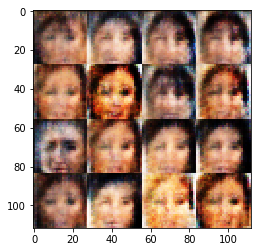

Epoch 0/1... Discriminator Loss: 1.0936... Generator Loss: 2.1555
Epoch 0/1... Discriminator Loss: 1.3204... Generator Loss: 0.6499
Epoch 0/1... Discriminator Loss: 1.0460... Generator Loss: 1.9731
Epoch 0/1... Discriminator Loss: 1.0470... Generator Loss: 1.8283
Epoch 0/1... Discriminator Loss: 1.5689... Generator Loss: 0.4893
Epoch 0/1... Discriminator Loss: 0.9500... Generator Loss: 1.3663
Epoch 0/1... Discriminator Loss: 1.2345... Generator Loss: 0.6529
Epoch 0/1... Discriminator Loss: 0.9908... Generator Loss: 1.1873
Epoch 0/1... Discriminator Loss: 0.8608... Generator Loss: 1.2880
Epoch 0/1... Discriminator Loss: 1.2367... Generator Loss: 0.8083


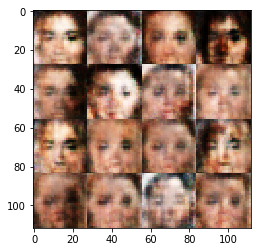

Epoch 0/1... Discriminator Loss: 1.8247... Generator Loss: 0.4121
Epoch 0/1... Discriminator Loss: 1.5609... Generator Loss: 0.5103
Epoch 0/1... Discriminator Loss: 0.9130... Generator Loss: 0.8792
Epoch 0/1... Discriminator Loss: 0.9183... Generator Loss: 1.1660
Epoch 0/1... Discriminator Loss: 0.9657... Generator Loss: 1.1647
Epoch 0/1... Discriminator Loss: 1.1651... Generator Loss: 0.8897
Epoch 0/1... Discriminator Loss: 1.5792... Generator Loss: 1.7984
Epoch 0/1... Discriminator Loss: 0.9250... Generator Loss: 1.2930
Epoch 0/1... Discriminator Loss: 1.7836... Generator Loss: 0.4095
Epoch 0/1... Discriminator Loss: 1.2807... Generator Loss: 0.5589


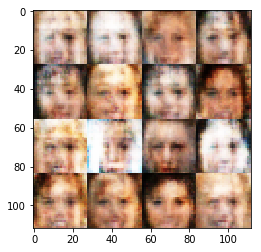

Epoch 0/1... Discriminator Loss: 1.0827... Generator Loss: 1.0413
Epoch 0/1... Discriminator Loss: 0.9095... Generator Loss: 1.1967
Epoch 0/1... Discriminator Loss: 1.1972... Generator Loss: 0.6353
Epoch 0/1... Discriminator Loss: 1.1093... Generator Loss: 0.7222
Epoch 0/1... Discriminator Loss: 1.0881... Generator Loss: 1.0313
Epoch 0/1... Discriminator Loss: 1.1151... Generator Loss: 0.7730
Epoch 0/1... Discriminator Loss: 0.9157... Generator Loss: 1.1804
Epoch 0/1... Discriminator Loss: 1.0953... Generator Loss: 0.9399
Epoch 0/1... Discriminator Loss: 1.2197... Generator Loss: 0.8910
Epoch 0/1... Discriminator Loss: 1.2059... Generator Loss: 0.6767


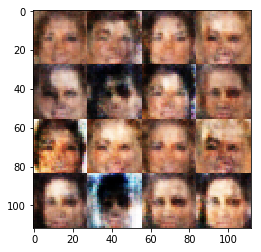

Epoch 0/1... Discriminator Loss: 1.3840... Generator Loss: 0.5437
Epoch 0/1... Discriminator Loss: 0.9435... Generator Loss: 1.0328
Epoch 0/1... Discriminator Loss: 1.2413... Generator Loss: 0.6737
Epoch 0/1... Discriminator Loss: 1.2177... Generator Loss: 0.6411
Epoch 0/1... Discriminator Loss: 1.0321... Generator Loss: 0.8030
Epoch 0/1... Discriminator Loss: 0.9171... Generator Loss: 1.7017
Epoch 0/1... Discriminator Loss: 1.2748... Generator Loss: 1.3197
Epoch 0/1... Discriminator Loss: 0.9255... Generator Loss: 1.3797
Epoch 0/1... Discriminator Loss: 0.9872... Generator Loss: 1.2779
Epoch 0/1... Discriminator Loss: 1.0253... Generator Loss: 1.4332


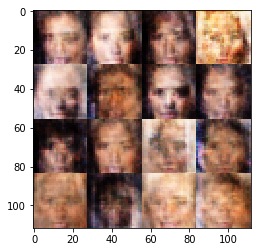

Epoch 0/1... Discriminator Loss: 0.9982... Generator Loss: 1.2482
Epoch 0/1... Discriminator Loss: 1.0104... Generator Loss: 0.7751
Epoch 0/1... Discriminator Loss: 1.1106... Generator Loss: 1.5091
Epoch 0/1... Discriminator Loss: 1.5239... Generator Loss: 2.3845
Epoch 0/1... Discriminator Loss: 1.7346... Generator Loss: 0.4264
Epoch 0/1... Discriminator Loss: 1.0024... Generator Loss: 1.3517
Epoch 0/1... Discriminator Loss: 1.1121... Generator Loss: 0.8053
Epoch 0/1... Discriminator Loss: 1.0502... Generator Loss: 1.2598
Epoch 0/1... Discriminator Loss: 1.4931... Generator Loss: 0.5158
Epoch 0/1... Discriminator Loss: 1.0328... Generator Loss: 0.7704


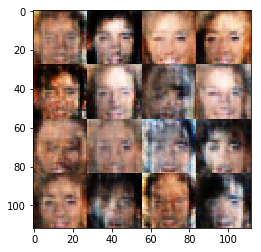

Epoch 0/1... Discriminator Loss: 1.0225... Generator Loss: 0.9707
Epoch 0/1... Discriminator Loss: 1.1176... Generator Loss: 1.9784
Epoch 0/1... Discriminator Loss: 0.9124... Generator Loss: 1.1881
Epoch 0/1... Discriminator Loss: 1.0143... Generator Loss: 1.1910
Epoch 0/1... Discriminator Loss: 1.0985... Generator Loss: 1.1086
Epoch 0/1... Discriminator Loss: 1.0544... Generator Loss: 1.1827
Epoch 0/1... Discriminator Loss: 1.1540... Generator Loss: 0.8523
Epoch 0/1... Discriminator Loss: 0.8052... Generator Loss: 1.2157
Epoch 0/1... Discriminator Loss: 1.3050... Generator Loss: 0.6205
Epoch 0/1... Discriminator Loss: 1.3428... Generator Loss: 2.2361


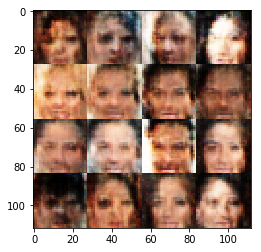

Epoch 0/1... Discriminator Loss: 0.8766... Generator Loss: 1.3055
Epoch 0/1... Discriminator Loss: 1.2040... Generator Loss: 0.6490
Epoch 0/1... Discriminator Loss: 1.2506... Generator Loss: 0.6354
Epoch 0/1... Discriminator Loss: 1.5254... Generator Loss: 2.3820
Epoch 0/1... Discriminator Loss: 1.0451... Generator Loss: 1.4809
Epoch 0/1... Discriminator Loss: 0.9166... Generator Loss: 1.1235
Epoch 0/1... Discriminator Loss: 1.1191... Generator Loss: 1.7124
Epoch 0/1... Discriminator Loss: 0.9037... Generator Loss: 1.0195
Epoch 0/1... Discriminator Loss: 1.1133... Generator Loss: 0.9904
Epoch 0/1... Discriminator Loss: 1.1513... Generator Loss: 0.6777


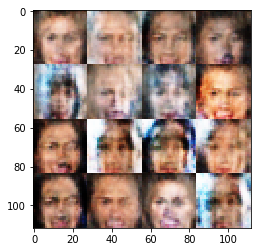

Epoch 0/1... Discriminator Loss: 1.1736... Generator Loss: 1.1671
Epoch 0/1... Discriminator Loss: 1.1204... Generator Loss: 0.7939
Epoch 0/1... Discriminator Loss: 1.1684... Generator Loss: 0.6743
Epoch 0/1... Discriminator Loss: 0.8738... Generator Loss: 1.2716
Epoch 0/1... Discriminator Loss: 0.9961... Generator Loss: 1.6674
Epoch 0/1... Discriminator Loss: 1.1254... Generator Loss: 0.9800
Epoch 0/1... Discriminator Loss: 1.5535... Generator Loss: 2.8061
Epoch 0/1... Discriminator Loss: 0.8693... Generator Loss: 1.0440
Epoch 0/1... Discriminator Loss: 0.9309... Generator Loss: 1.6460
Epoch 0/1... Discriminator Loss: 1.2230... Generator Loss: 0.6635


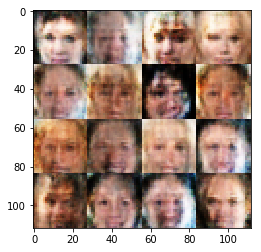

Epoch 0/1... Discriminator Loss: 1.4766... Generator Loss: 0.5661
Epoch 0/1... Discriminator Loss: 1.1874... Generator Loss: 0.6333
Epoch 0/1... Discriminator Loss: 1.0000... Generator Loss: 0.8312
Epoch 0/1... Discriminator Loss: 0.8427... Generator Loss: 1.0742
Epoch 0/1... Discriminator Loss: 0.9996... Generator Loss: 1.3385
Epoch 0/1... Discriminator Loss: 1.3204... Generator Loss: 0.5640
Epoch 0/1... Discriminator Loss: 1.4213... Generator Loss: 0.5654
Epoch 0/1... Discriminator Loss: 1.0941... Generator Loss: 1.7798
Epoch 0/1... Discriminator Loss: 1.0061... Generator Loss: 0.9902
Epoch 0/1... Discriminator Loss: 1.4316... Generator Loss: 0.5935


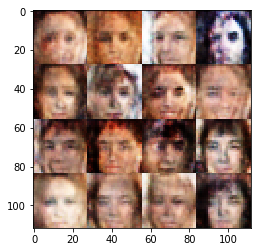

Epoch 0/1... Discriminator Loss: 0.8785... Generator Loss: 1.8011
Epoch 0/1... Discriminator Loss: 0.9529... Generator Loss: 1.1708
Epoch 0/1... Discriminator Loss: 0.8513... Generator Loss: 1.5145
Epoch 0/1... Discriminator Loss: 1.1484... Generator Loss: 1.6384
Epoch 0/1... Discriminator Loss: 1.1210... Generator Loss: 0.6704
Epoch 0/1... Discriminator Loss: 1.0102... Generator Loss: 1.2440
Epoch 0/1... Discriminator Loss: 1.0164... Generator Loss: 1.9690
Epoch 0/1... Discriminator Loss: 0.9757... Generator Loss: 1.3352
Epoch 0/1... Discriminator Loss: 1.0210... Generator Loss: 1.4357
Epoch 0/1... Discriminator Loss: 1.0679... Generator Loss: 1.5074


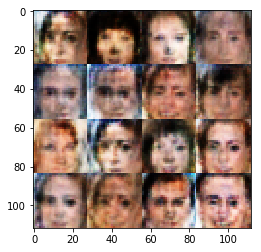

Epoch 0/1... Discriminator Loss: 0.9748... Generator Loss: 0.9424
Epoch 0/1... Discriminator Loss: 0.9749... Generator Loss: 1.1111
Epoch 0/1... Discriminator Loss: 1.0391... Generator Loss: 1.1192
Epoch 0/1... Discriminator Loss: 1.0510... Generator Loss: 0.8170
Epoch 0/1... Discriminator Loss: 1.2636... Generator Loss: 2.1852
Epoch 0/1... Discriminator Loss: 1.2982... Generator Loss: 0.5786
Epoch 0/1... Discriminator Loss: 0.9598... Generator Loss: 2.3181
Epoch 0/1... Discriminator Loss: 1.2011... Generator Loss: 0.6892
Epoch 0/1... Discriminator Loss: 1.0034... Generator Loss: 0.9891
Epoch 0/1... Discriminator Loss: 0.9839... Generator Loss: 1.0688


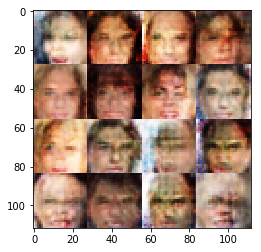

Epoch 0/1... Discriminator Loss: 0.9342... Generator Loss: 1.4170
Epoch 0/1... Discriminator Loss: 0.9603... Generator Loss: 0.9686
Epoch 0/1... Discriminator Loss: 1.1935... Generator Loss: 0.6180
Epoch 0/1... Discriminator Loss: 1.1388... Generator Loss: 0.7697
Epoch 0/1... Discriminator Loss: 1.3034... Generator Loss: 2.3287
Epoch 0/1... Discriminator Loss: 1.8016... Generator Loss: 3.4279
Epoch 0/1... Discriminator Loss: 1.0817... Generator Loss: 1.0284
Epoch 0/1... Discriminator Loss: 0.9564... Generator Loss: 1.8750
Epoch 0/1... Discriminator Loss: 0.9190... Generator Loss: 0.9958
Epoch 0/1... Discriminator Loss: 0.8790... Generator Loss: 1.6689


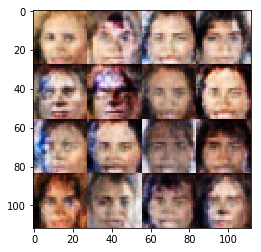

Epoch 0/1... Discriminator Loss: 0.9979... Generator Loss: 1.2247
Epoch 0/1... Discriminator Loss: 1.0803... Generator Loss: 2.1505
Epoch 0/1... Discriminator Loss: 1.0436... Generator Loss: 1.0691
Epoch 0/1... Discriminator Loss: 1.3214... Generator Loss: 0.6723
Epoch 0/1... Discriminator Loss: 1.1012... Generator Loss: 1.5676
Epoch 0/1... Discriminator Loss: 1.0353... Generator Loss: 0.7874
Epoch 0/1... Discriminator Loss: 1.3370... Generator Loss: 0.6011
Epoch 0/1... Discriminator Loss: 1.1188... Generator Loss: 1.8762
Epoch 0/1... Discriminator Loss: 1.2107... Generator Loss: 0.6316
Epoch 0/1... Discriminator Loss: 1.1454... Generator Loss: 0.7603


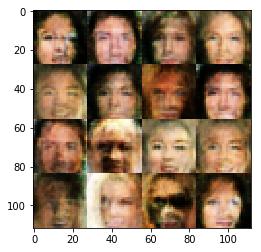

Epoch 0/1... Discriminator Loss: 1.0723... Generator Loss: 0.7859
Epoch 0/1... Discriminator Loss: 1.1532... Generator Loss: 0.8407
Epoch 0/1... Discriminator Loss: 0.8524... Generator Loss: 0.9722
Epoch 0/1... Discriminator Loss: 1.4367... Generator Loss: 0.5532
Epoch 0/1... Discriminator Loss: 1.1156... Generator Loss: 0.6965
Epoch 0/1... Discriminator Loss: 0.9030... Generator Loss: 1.7873
Epoch 0/1... Discriminator Loss: 1.4273... Generator Loss: 0.5637
Epoch 0/1... Discriminator Loss: 1.0706... Generator Loss: 1.5498
Epoch 0/1... Discriminator Loss: 1.0668... Generator Loss: 0.6987
Epoch 0/1... Discriminator Loss: 1.3398... Generator Loss: 2.2981


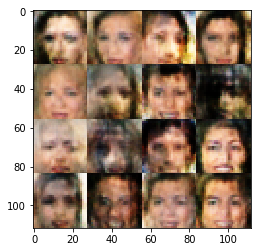

Epoch 0/1... Discriminator Loss: 1.0104... Generator Loss: 1.0447
Epoch 0/1... Discriminator Loss: 1.0227... Generator Loss: 0.7576
Epoch 0/1... Discriminator Loss: 0.9840... Generator Loss: 1.0352
Epoch 0/1... Discriminator Loss: 0.9508... Generator Loss: 1.1402
Epoch 0/1... Discriminator Loss: 0.9717... Generator Loss: 1.4380
Epoch 0/1... Discriminator Loss: 1.0052... Generator Loss: 1.0841
Epoch 0/1... Discriminator Loss: 1.2063... Generator Loss: 0.5523
Epoch 0/1... Discriminator Loss: 0.8277... Generator Loss: 1.2119
Epoch 0/1... Discriminator Loss: 1.2480... Generator Loss: 0.6099
Epoch 0/1... Discriminator Loss: 1.0926... Generator Loss: 0.9572


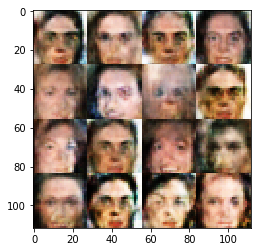

Epoch 0/1... Discriminator Loss: 1.5718... Generator Loss: 0.4756
Epoch 0/1... Discriminator Loss: 1.2886... Generator Loss: 0.6877
Epoch 0/1... Discriminator Loss: 0.7726... Generator Loss: 1.1751
Epoch 0/1... Discriminator Loss: 0.8872... Generator Loss: 1.6252
Epoch 0/1... Discriminator Loss: 1.4781... Generator Loss: 0.5534
Epoch 0/1... Discriminator Loss: 1.3823... Generator Loss: 0.5895
Epoch 0/1... Discriminator Loss: 0.9648... Generator Loss: 0.8265
Epoch 0/1... Discriminator Loss: 0.9546... Generator Loss: 2.5629
Epoch 0/1... Discriminator Loss: 1.1170... Generator Loss: 0.7007
Epoch 0/1... Discriminator Loss: 1.0912... Generator Loss: 0.6162


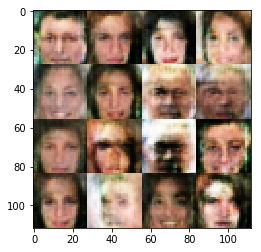

Epoch 0/1... Discriminator Loss: 1.3548... Generator Loss: 0.6017
Epoch 0/1... Discriminator Loss: 1.2982... Generator Loss: 1.8533
Epoch 0/1... Discriminator Loss: 0.7882... Generator Loss: 1.2669
Epoch 0/1... Discriminator Loss: 1.3588... Generator Loss: 2.0177
Epoch 0/1... Discriminator Loss: 1.0530... Generator Loss: 0.7679
Epoch 0/1... Discriminator Loss: 0.9086... Generator Loss: 1.3591
Epoch 0/1... Discriminator Loss: 0.9635... Generator Loss: 0.8828
Epoch 0/1... Discriminator Loss: 1.2145... Generator Loss: 0.6952
Epoch 0/1... Discriminator Loss: 0.9917... Generator Loss: 0.8087
Epoch 0/1... Discriminator Loss: 1.0607... Generator Loss: 0.8700


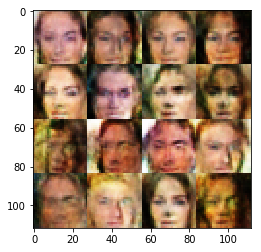

Epoch 0/1... Discriminator Loss: 1.1040... Generator Loss: 1.4672
Epoch 0/1... Discriminator Loss: 1.0189... Generator Loss: 2.4124
Epoch 0/1... Discriminator Loss: 1.0312... Generator Loss: 0.8402
Epoch 0/1... Discriminator Loss: 1.0801... Generator Loss: 0.8429
Epoch 0/1... Discriminator Loss: 1.5566... Generator Loss: 0.5125
Epoch 0/1... Discriminator Loss: 0.9440... Generator Loss: 0.8574
Epoch 0/1... Discriminator Loss: 1.0019... Generator Loss: 1.0964
Epoch 0/1... Discriminator Loss: 1.3855... Generator Loss: 0.5657
Epoch 0/1... Discriminator Loss: 1.0200... Generator Loss: 0.9318
Epoch 0/1... Discriminator Loss: 1.0635... Generator Loss: 0.7027


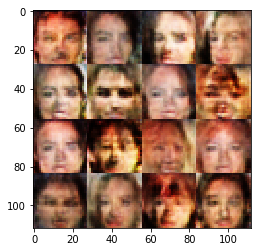

Epoch 0/1... Discriminator Loss: 0.8743... Generator Loss: 1.3179
Epoch 0/1... Discriminator Loss: 0.8264... Generator Loss: 1.6837
Epoch 0/1... Discriminator Loss: 1.0084... Generator Loss: 1.3350
Epoch 0/1... Discriminator Loss: 0.8814... Generator Loss: 1.3188
Epoch 0/1... Discriminator Loss: 1.2262... Generator Loss: 1.1643
Epoch 0/1... Discriminator Loss: 1.2985... Generator Loss: 2.0094
Epoch 0/1... Discriminator Loss: 0.9060... Generator Loss: 0.9284
Epoch 0/1... Discriminator Loss: 1.2643... Generator Loss: 0.6198
Epoch 0/1... Discriminator Loss: 0.9031... Generator Loss: 1.8687
Epoch 0/1... Discriminator Loss: 0.9939... Generator Loss: 1.3882


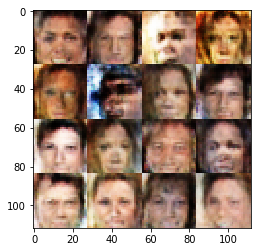

Epoch 0/1... Discriminator Loss: 1.2522... Generator Loss: 0.6404
Epoch 0/1... Discriminator Loss: 1.1569... Generator Loss: 0.8578
Epoch 0/1... Discriminator Loss: 0.8949... Generator Loss: 1.5066
Epoch 0/1... Discriminator Loss: 0.9075... Generator Loss: 1.4563
Epoch 0/1... Discriminator Loss: 1.1752... Generator Loss: 0.6858
Epoch 0/1... Discriminator Loss: 0.8921... Generator Loss: 1.1002
Epoch 0/1... Discriminator Loss: 1.0350... Generator Loss: 0.9143
Epoch 0/1... Discriminator Loss: 1.0517... Generator Loss: 1.5386
Epoch 0/1... Discriminator Loss: 0.8608... Generator Loss: 1.4573
Epoch 0/1... Discriminator Loss: 1.0197... Generator Loss: 0.9994


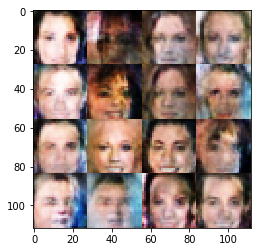

Epoch 0/1... Discriminator Loss: 0.8630... Generator Loss: 1.3631
Epoch 0/1... Discriminator Loss: 1.0663... Generator Loss: 0.7583
Epoch 0/1... Discriminator Loss: 1.6049... Generator Loss: 0.4420
Epoch 0/1... Discriminator Loss: 1.2777... Generator Loss: 0.6517
Epoch 0/1... Discriminator Loss: 0.9329... Generator Loss: 0.8771
Epoch 0/1... Discriminator Loss: 1.0849... Generator Loss: 0.7560
Epoch 0/1... Discriminator Loss: 1.1656... Generator Loss: 0.7370
Epoch 0/1... Discriminator Loss: 1.2012... Generator Loss: 0.6277
Epoch 0/1... Discriminator Loss: 1.1897... Generator Loss: 0.6339
Epoch 0/1... Discriminator Loss: 1.0560... Generator Loss: 0.8414


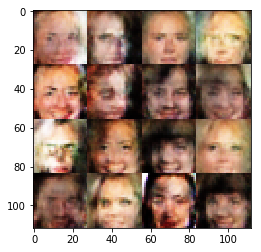

Epoch 0/1... Discriminator Loss: 1.1038... Generator Loss: 1.6416
Epoch 0/1... Discriminator Loss: 1.1949... Generator Loss: 2.1018
Epoch 0/1... Discriminator Loss: 0.9126... Generator Loss: 1.1367
Epoch 0/1... Discriminator Loss: 0.8824... Generator Loss: 1.7257
Epoch 0/1... Discriminator Loss: 1.1133... Generator Loss: 0.7100
Epoch 0/1... Discriminator Loss: 0.8632... Generator Loss: 1.2029
Epoch 0/1... Discriminator Loss: 0.9819... Generator Loss: 0.9385
Epoch 0/1... Discriminator Loss: 0.8636... Generator Loss: 1.8707
Epoch 0/1... Discriminator Loss: 0.9968... Generator Loss: 0.8224
Epoch 0/1... Discriminator Loss: 0.8245... Generator Loss: 1.1762


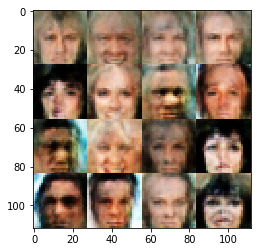

Epoch 0/1... Discriminator Loss: 0.9887... Generator Loss: 0.9283
Epoch 0/1... Discriminator Loss: 1.3928... Generator Loss: 0.5339
Epoch 0/1... Discriminator Loss: 1.2109... Generator Loss: 0.6980
Epoch 0/1... Discriminator Loss: 1.2578... Generator Loss: 1.8950
Epoch 0/1... Discriminator Loss: 1.3914... Generator Loss: 0.5785
Epoch 0/1... Discriminator Loss: 1.0966... Generator Loss: 1.1080
Epoch 0/1... Discriminator Loss: 0.8290... Generator Loss: 1.5814
Epoch 0/1... Discriminator Loss: 1.2739... Generator Loss: 0.5683
Epoch 0/1... Discriminator Loss: 1.0775... Generator Loss: 0.9543
Epoch 0/1... Discriminator Loss: 1.1257... Generator Loss: 0.6782


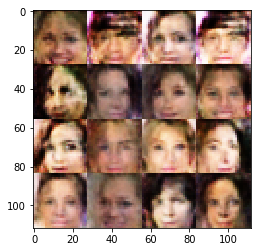

Epoch 0/1... Discriminator Loss: 1.1193... Generator Loss: 0.9485
Epoch 0/1... Discriminator Loss: 1.1213... Generator Loss: 0.7687
Epoch 0/1... Discriminator Loss: 1.0467... Generator Loss: 0.9702
Epoch 0/1... Discriminator Loss: 1.1498... Generator Loss: 0.8350
Epoch 0/1... Discriminator Loss: 1.2837... Generator Loss: 0.6296
Epoch 0/1... Discriminator Loss: 1.8404... Generator Loss: 3.0640
Epoch 0/1... Discriminator Loss: 1.2319... Generator Loss: 0.6881
Epoch 0/1... Discriminator Loss: 0.9418... Generator Loss: 1.4700
Epoch 0/1... Discriminator Loss: 1.0754... Generator Loss: 1.4842
Epoch 0/1... Discriminator Loss: 1.1282... Generator Loss: 1.4720


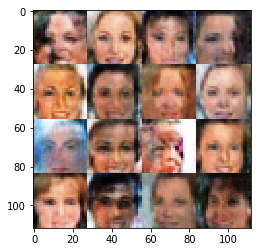

Epoch 0/1... Discriminator Loss: 1.0131... Generator Loss: 0.8095
Epoch 0/1... Discriminator Loss: 0.9993... Generator Loss: 1.2280
Epoch 0/1... Discriminator Loss: 1.2572... Generator Loss: 0.6177
Epoch 0/1... Discriminator Loss: 0.9000... Generator Loss: 1.2159
Epoch 0/1... Discriminator Loss: 1.3013... Generator Loss: 0.5357
Epoch 0/1... Discriminator Loss: 1.3003... Generator Loss: 0.5649
Epoch 0/1... Discriminator Loss: 0.8989... Generator Loss: 1.3946
Epoch 0/1... Discriminator Loss: 1.0742... Generator Loss: 0.7825
Epoch 0/1... Discriminator Loss: 1.1709... Generator Loss: 0.7472
Epoch 0/1... Discriminator Loss: 1.2842... Generator Loss: 0.5987


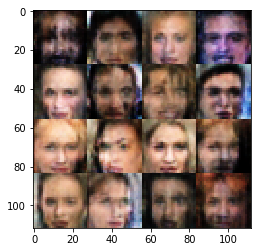

Epoch 0/1... Discriminator Loss: 1.3314... Generator Loss: 1.7873
Epoch 0/1... Discriminator Loss: 0.7040... Generator Loss: 1.1814
Epoch 0/1... Discriminator Loss: 1.1863... Generator Loss: 0.9490
Epoch 0/1... Discriminator Loss: 1.2460... Generator Loss: 2.0746
Epoch 0/1... Discriminator Loss: 0.8800... Generator Loss: 1.5574
Epoch 0/1... Discriminator Loss: 1.1373... Generator Loss: 0.7534
Epoch 0/1... Discriminator Loss: 1.0239... Generator Loss: 2.2661
Epoch 0/1... Discriminator Loss: 1.0192... Generator Loss: 1.4225
Epoch 0/1... Discriminator Loss: 1.3534... Generator Loss: 0.5449
Epoch 0/1... Discriminator Loss: 1.0965... Generator Loss: 0.8196


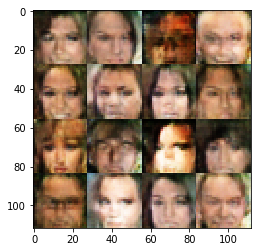

Epoch 0/1... Discriminator Loss: 1.1205... Generator Loss: 2.3234
Epoch 0/1... Discriminator Loss: 0.9062... Generator Loss: 1.3269
Epoch 0/1... Discriminator Loss: 0.8868... Generator Loss: 1.1959
Epoch 0/1... Discriminator Loss: 1.4972... Generator Loss: 0.5216
Epoch 0/1... Discriminator Loss: 1.0773... Generator Loss: 0.9137
Epoch 0/1... Discriminator Loss: 1.0280... Generator Loss: 0.7659
Epoch 0/1... Discriminator Loss: 1.0376... Generator Loss: 0.7295
Epoch 0/1... Discriminator Loss: 1.0005... Generator Loss: 2.0587
Epoch 0/1... Discriminator Loss: 0.9742... Generator Loss: 1.3719
Epoch 0/1... Discriminator Loss: 1.1408... Generator Loss: 0.9158


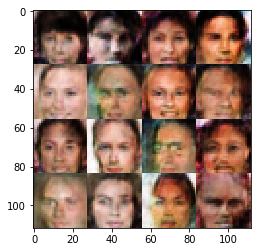

Epoch 0/1... Discriminator Loss: 0.7772... Generator Loss: 1.4721
Epoch 0/1... Discriminator Loss: 1.0688... Generator Loss: 0.7059
Epoch 0/1... Discriminator Loss: 0.8792... Generator Loss: 1.2083
Epoch 0/1... Discriminator Loss: 0.9891... Generator Loss: 1.3955
Epoch 0/1... Discriminator Loss: 1.1746... Generator Loss: 0.6628
Epoch 0/1... Discriminator Loss: 0.8840... Generator Loss: 1.5892
Epoch 0/1... Discriminator Loss: 1.0706... Generator Loss: 0.8044
Epoch 0/1... Discriminator Loss: 1.0035... Generator Loss: 1.1836
Epoch 0/1... Discriminator Loss: 1.0559... Generator Loss: 0.7694
Epoch 0/1... Discriminator Loss: 0.8089... Generator Loss: 1.4283


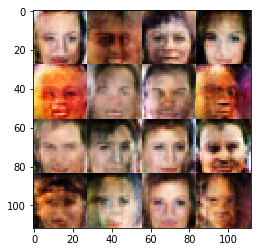

Epoch 0/1... Discriminator Loss: 1.0142... Generator Loss: 0.8507
Epoch 0/1... Discriminator Loss: 0.8842... Generator Loss: 1.6905
Epoch 0/1... Discriminator Loss: 1.0290... Generator Loss: 1.1313
Epoch 0/1... Discriminator Loss: 1.0059... Generator Loss: 0.9678
Epoch 0/1... Discriminator Loss: 0.9039... Generator Loss: 0.9906
Epoch 0/1... Discriminator Loss: 0.9603... Generator Loss: 1.3559
Epoch 0/1... Discriminator Loss: 0.8215... Generator Loss: 1.3186
Epoch 0/1... Discriminator Loss: 0.8923... Generator Loss: 1.3151
Epoch 0/1... Discriminator Loss: 1.6931... Generator Loss: 0.4600
Epoch 0/1... Discriminator Loss: 0.9175... Generator Loss: 1.4466


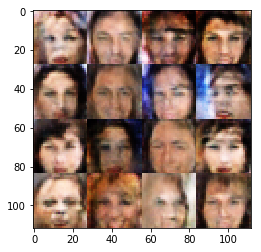

Epoch 0/1... Discriminator Loss: 1.2039... Generator Loss: 0.7362
Epoch 0/1... Discriminator Loss: 0.8378... Generator Loss: 1.9675
Epoch 0/1... Discriminator Loss: 0.9368... Generator Loss: 0.8495
Epoch 0/1... Discriminator Loss: 0.8781... Generator Loss: 0.8920
Epoch 0/1... Discriminator Loss: 1.3567... Generator Loss: 1.8178
Epoch 0/1... Discriminator Loss: 1.2561... Generator Loss: 0.6023
Epoch 0/1... Discriminator Loss: 0.9934... Generator Loss: 1.3811
Epoch 0/1... Discriminator Loss: 0.7773... Generator Loss: 1.5201
Epoch 0/1... Discriminator Loss: 1.1619... Generator Loss: 0.7311
Epoch 0/1... Discriminator Loss: 1.1000... Generator Loss: 0.8206


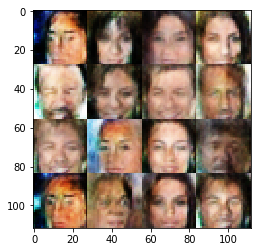

Epoch 0/1... Discriminator Loss: 1.1587... Generator Loss: 0.7536
Epoch 0/1... Discriminator Loss: 0.7800... Generator Loss: 1.4360
Epoch 0/1... Discriminator Loss: 1.3590... Generator Loss: 2.1052
Epoch 0/1... Discriminator Loss: 0.8360... Generator Loss: 1.6972
Epoch 0/1... Discriminator Loss: 1.5050... Generator Loss: 0.4555
Epoch 0/1... Discriminator Loss: 1.7317... Generator Loss: 2.0532
Epoch 0/1... Discriminator Loss: 0.8830... Generator Loss: 0.9956
Epoch 0/1... Discriminator Loss: 1.2151... Generator Loss: 1.6482
Epoch 0/1... Discriminator Loss: 0.9310... Generator Loss: 0.7945
Epoch 0/1... Discriminator Loss: 1.1170... Generator Loss: 0.7194


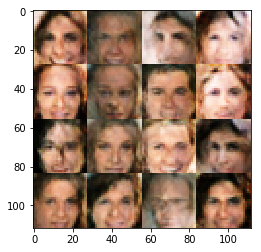

Epoch 0/1... Discriminator Loss: 0.9855... Generator Loss: 0.9289
Epoch 0/1... Discriminator Loss: 0.8307... Generator Loss: 1.1499
Epoch 0/1... Discriminator Loss: 1.2218... Generator Loss: 0.6456
Epoch 0/1... Discriminator Loss: 1.0890... Generator Loss: 0.7422
Epoch 0/1... Discriminator Loss: 0.9173... Generator Loss: 0.9444
Epoch 0/1... Discriminator Loss: 0.8990... Generator Loss: 1.1367
Epoch 0/1... Discriminator Loss: 0.8136... Generator Loss: 1.4682
Epoch 0/1... Discriminator Loss: 1.2885... Generator Loss: 0.6132
Epoch 0/1... Discriminator Loss: 0.9101... Generator Loss: 1.5136
Epoch 0/1... Discriminator Loss: 0.9235... Generator Loss: 0.9798


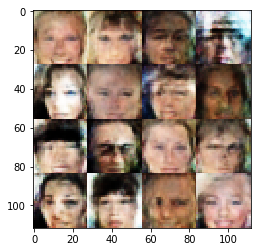

Epoch 0/1... Discriminator Loss: 1.0776... Generator Loss: 0.8552
Epoch 0/1... Discriminator Loss: 0.8290... Generator Loss: 1.4543
Epoch 0/1... Discriminator Loss: 1.1996... Generator Loss: 0.6952
Epoch 0/1... Discriminator Loss: 0.9845... Generator Loss: 0.7623
Epoch 0/1... Discriminator Loss: 1.1493... Generator Loss: 0.7913
Epoch 0/1... Discriminator Loss: 0.9783... Generator Loss: 0.8512
Epoch 0/1... Discriminator Loss: 0.8641... Generator Loss: 1.7761
Epoch 0/1... Discriminator Loss: 1.1531... Generator Loss: 0.6985
Epoch 0/1... Discriminator Loss: 0.9240... Generator Loss: 1.0191
Epoch 0/1... Discriminator Loss: 0.8593... Generator Loss: 1.4059


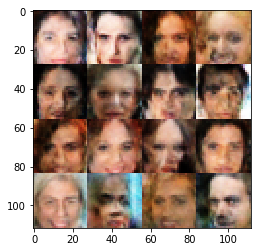

Epoch 0/1... Discriminator Loss: 1.0592... Generator Loss: 1.6314
Epoch 0/1... Discriminator Loss: 0.9742... Generator Loss: 1.0795
Epoch 0/1... Discriminator Loss: 1.4002... Generator Loss: 0.5333
Epoch 0/1... Discriminator Loss: 0.8876... Generator Loss: 1.1593
Epoch 0/1... Discriminator Loss: 1.0202... Generator Loss: 1.4067
Epoch 0/1... Discriminator Loss: 1.2804... Generator Loss: 0.6202
Epoch 0/1... Discriminator Loss: 0.8877... Generator Loss: 1.0841
Epoch 0/1... Discriminator Loss: 1.1658... Generator Loss: 0.6559
Epoch 0/1... Discriminator Loss: 0.9613... Generator Loss: 0.9216
Epoch 0/1... Discriminator Loss: 1.1159... Generator Loss: 0.7938


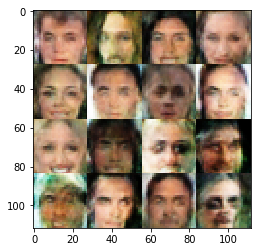

Epoch 0/1... Discriminator Loss: 0.8016... Generator Loss: 1.1664
Epoch 0/1... Discriminator Loss: 1.1041... Generator Loss: 1.3274
Epoch 0/1... Discriminator Loss: 1.3136... Generator Loss: 0.5740
Epoch 0/1... Discriminator Loss: 0.7724... Generator Loss: 1.3810
Epoch 0/1... Discriminator Loss: 0.9690... Generator Loss: 0.9674
Epoch 0/1... Discriminator Loss: 0.9910... Generator Loss: 1.2537
Epoch 0/1... Discriminator Loss: 1.2229... Generator Loss: 0.6688
Epoch 0/1... Discriminator Loss: 0.7685... Generator Loss: 1.3035
Epoch 0/1... Discriminator Loss: 0.9247... Generator Loss: 1.1090
Epoch 0/1... Discriminator Loss: 0.9354... Generator Loss: 1.5418


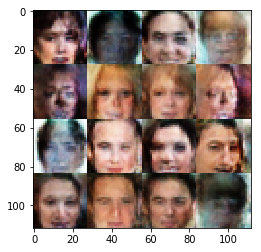

Epoch 0/1... Discriminator Loss: 1.3882... Generator Loss: 0.6198
Epoch 0/1... Discriminator Loss: 0.7580... Generator Loss: 1.2505
Epoch 0/1... Discriminator Loss: 1.0347... Generator Loss: 0.8704
Epoch 0/1... Discriminator Loss: 0.8990... Generator Loss: 1.0974
Epoch 0/1... Discriminator Loss: 1.1171... Generator Loss: 0.7022
Epoch 0/1... Discriminator Loss: 1.2245... Generator Loss: 0.6435
Epoch 0/1... Discriminator Loss: 1.3461... Generator Loss: 2.2007
Epoch 0/1... Discriminator Loss: 0.8654... Generator Loss: 1.4186
Epoch 0/1... Discriminator Loss: 0.9238... Generator Loss: 1.5613
Epoch 0/1... Discriminator Loss: 0.9850... Generator Loss: 1.6284


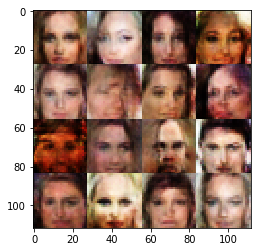

Epoch 0/1... Discriminator Loss: 1.3972... Generator Loss: 0.5057
Epoch 0/1... Discriminator Loss: 0.8526... Generator Loss: 1.6825
Epoch 0/1... Discriminator Loss: 1.1243... Generator Loss: 2.3731
Epoch 0/1... Discriminator Loss: 0.8150... Generator Loss: 1.4524
Epoch 0/1... Discriminator Loss: 1.3441... Generator Loss: 0.5619
Epoch 0/1... Discriminator Loss: 0.8502... Generator Loss: 1.0007
Epoch 0/1... Discriminator Loss: 1.1008... Generator Loss: 0.7974
Epoch 0/1... Discriminator Loss: 1.0006... Generator Loss: 0.8882
Epoch 0/1... Discriminator Loss: 0.9180... Generator Loss: 1.2417
Epoch 0/1... Discriminator Loss: 1.1552... Generator Loss: 0.7255


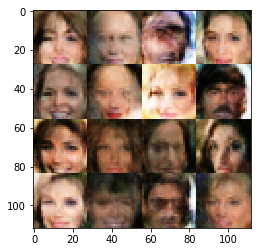

Epoch 0/1... Discriminator Loss: 1.0296... Generator Loss: 1.1405
Epoch 0/1... Discriminator Loss: 1.0337... Generator Loss: 1.0606
Epoch 0/1... Discriminator Loss: 1.4770... Generator Loss: 0.5983
Epoch 0/1... Discriminator Loss: 1.0071... Generator Loss: 1.1711
Epoch 0/1... Discriminator Loss: 1.0055... Generator Loss: 0.9027
Epoch 0/1... Discriminator Loss: 1.2960... Generator Loss: 0.5666
Epoch 0/1... Discriminator Loss: 0.9283... Generator Loss: 1.0308
Epoch 0/1... Discriminator Loss: 0.9865... Generator Loss: 0.8456
Epoch 0/1... Discriminator Loss: 0.8805... Generator Loss: 1.0191
Epoch 0/1... Discriminator Loss: 0.9545... Generator Loss: 0.8373


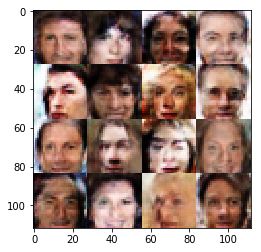

Epoch 0/1... Discriminator Loss: 1.1499... Generator Loss: 0.8696
Epoch 0/1... Discriminator Loss: 1.0476... Generator Loss: 1.4117
Epoch 0/1... Discriminator Loss: 0.9862... Generator Loss: 1.9186
Epoch 0/1... Discriminator Loss: 1.0193... Generator Loss: 0.7936
Epoch 0/1... Discriminator Loss: 1.0307... Generator Loss: 0.7521
Epoch 0/1... Discriminator Loss: 1.2633... Generator Loss: 0.5667
Epoch 0/1... Discriminator Loss: 0.9122... Generator Loss: 0.8517
Epoch 0/1... Discriminator Loss: 1.6015... Generator Loss: 0.4470
Epoch 0/1... Discriminator Loss: 0.9483... Generator Loss: 1.5456
Epoch 0/1... Discriminator Loss: 1.1219... Generator Loss: 1.1425


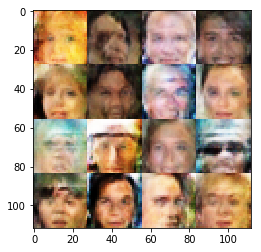

Epoch 0/1... Discriminator Loss: 0.9895... Generator Loss: 1.3139
Epoch 0/1... Discriminator Loss: 0.9396... Generator Loss: 1.1178
Epoch 0/1... Discriminator Loss: 1.0751... Generator Loss: 1.9913
Epoch 0/1... Discriminator Loss: 0.7473... Generator Loss: 1.1076
Epoch 0/1... Discriminator Loss: 0.9570... Generator Loss: 1.1998
Epoch 0/1... Discriminator Loss: 0.8247... Generator Loss: 1.0152
Epoch 0/1... Discriminator Loss: 0.9278... Generator Loss: 1.1689
Epoch 0/1... Discriminator Loss: 1.1526... Generator Loss: 0.8042
Epoch 0/1... Discriminator Loss: 1.5139... Generator Loss: 0.5090
Epoch 0/1... Discriminator Loss: 1.1563... Generator Loss: 1.4629


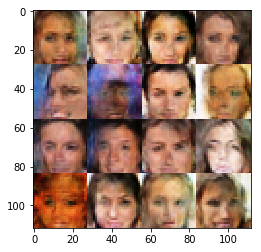

Epoch 0/1... Discriminator Loss: 0.9772... Generator Loss: 0.7303
Epoch 0/1... Discriminator Loss: 1.1276... Generator Loss: 0.7021
Epoch 0/1... Discriminator Loss: 0.9259... Generator Loss: 1.2209
Epoch 0/1... Discriminator Loss: 1.4813... Generator Loss: 0.5064
Epoch 0/1... Discriminator Loss: 0.9381... Generator Loss: 1.0809
Epoch 0/1... Discriminator Loss: 0.9294... Generator Loss: 0.9795
Epoch 0/1... Discriminator Loss: 1.1858... Generator Loss: 0.5858
Epoch 0/1... Discriminator Loss: 0.9520... Generator Loss: 0.9004
Epoch 0/1... Discriminator Loss: 1.0549... Generator Loss: 0.9636
Epoch 0/1... Discriminator Loss: 1.0156... Generator Loss: 1.1256


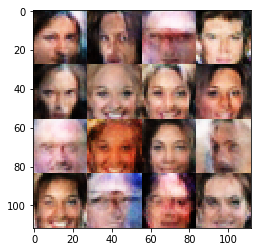

Epoch 0/1... Discriminator Loss: 0.9703... Generator Loss: 0.9222
Epoch 0/1... Discriminator Loss: 1.2595... Generator Loss: 2.7403
Epoch 0/1... Discriminator Loss: 1.3652... Generator Loss: 0.5609
Epoch 0/1... Discriminator Loss: 1.0157... Generator Loss: 1.6341
Epoch 0/1... Discriminator Loss: 0.9638... Generator Loss: 1.3152
Epoch 0/1... Discriminator Loss: 0.9895... Generator Loss: 0.8965
Epoch 0/1... Discriminator Loss: 1.3326... Generator Loss: 0.5535
Epoch 0/1... Discriminator Loss: 0.7260... Generator Loss: 1.3567
Epoch 0/1... Discriminator Loss: 0.9374... Generator Loss: 1.1418
Epoch 0/1... Discriminator Loss: 0.6123... Generator Loss: 1.8032


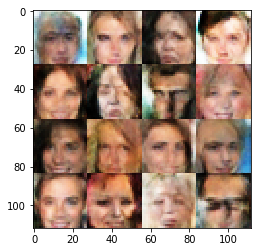

Epoch 0/1... Discriminator Loss: 0.8984... Generator Loss: 0.8945
Epoch 0/1... Discriminator Loss: 1.1876... Generator Loss: 0.5580
Epoch 0/1... Discriminator Loss: 1.0395... Generator Loss: 1.8933
Epoch 0/1... Discriminator Loss: 1.0673... Generator Loss: 0.7285
Epoch 0/1... Discriminator Loss: 0.9466... Generator Loss: 1.1326
Epoch 0/1... Discriminator Loss: 1.2645... Generator Loss: 2.2267
Epoch 0/1... Discriminator Loss: 1.2795... Generator Loss: 0.6452
Epoch 0/1... Discriminator Loss: 0.9580... Generator Loss: 0.9567
Epoch 0/1... Discriminator Loss: 0.8877... Generator Loss: 1.7263
Epoch 0/1... Discriminator Loss: 1.1713... Generator Loss: 0.6538


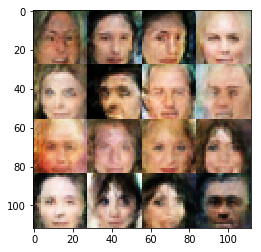

Epoch 0/1... Discriminator Loss: 1.0664... Generator Loss: 1.6492
Epoch 0/1... Discriminator Loss: 0.8651... Generator Loss: 1.0825
Epoch 0/1... Discriminator Loss: 0.8377... Generator Loss: 0.9828
Epoch 0/1... Discriminator Loss: 1.1923... Generator Loss: 0.7249
Epoch 0/1... Discriminator Loss: 1.4351... Generator Loss: 0.5825
Epoch 0/1... Discriminator Loss: 1.2120... Generator Loss: 0.9277
Epoch 0/1... Discriminator Loss: 0.8847... Generator Loss: 1.2300
Epoch 0/1... Discriminator Loss: 0.8853... Generator Loss: 1.2461
Epoch 0/1... Discriminator Loss: 1.0271... Generator Loss: 0.8220
Epoch 0/1... Discriminator Loss: 1.2253... Generator Loss: 0.6617


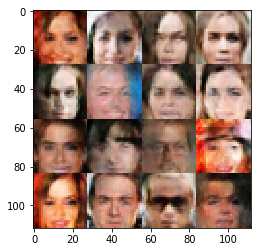

Epoch 0/1... Discriminator Loss: 1.5416... Generator Loss: 0.5476
Epoch 0/1... Discriminator Loss: 0.9220... Generator Loss: 1.0222
Epoch 0/1... Discriminator Loss: 0.8193... Generator Loss: 1.3301
Epoch 0/1... Discriminator Loss: 1.0211... Generator Loss: 0.8615
Epoch 0/1... Discriminator Loss: 0.8932... Generator Loss: 0.9595
Epoch 0/1... Discriminator Loss: 0.9222... Generator Loss: 0.9777
Epoch 0/1... Discriminator Loss: 0.8998... Generator Loss: 0.8242
Epoch 0/1... Discriminator Loss: 1.1443... Generator Loss: 0.8045
Epoch 0/1... Discriminator Loss: 1.1694... Generator Loss: 0.6463
Epoch 0/1... Discriminator Loss: 1.4282... Generator Loss: 2.2813


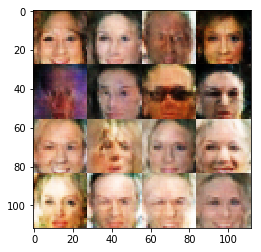

Epoch 0/1... Discriminator Loss: 0.7927... Generator Loss: 1.2314
Epoch 0/1... Discriminator Loss: 0.7776... Generator Loss: 1.8308
Epoch 0/1... Discriminator Loss: 0.8955... Generator Loss: 1.3205
Epoch 0/1... Discriminator Loss: 0.7370... Generator Loss: 2.0913
Epoch 0/1... Discriminator Loss: 1.1417... Generator Loss: 0.7420
Epoch 0/1... Discriminator Loss: 1.2018... Generator Loss: 0.7272
Epoch 0/1... Discriminator Loss: 0.9667... Generator Loss: 0.7882
Epoch 0/1... Discriminator Loss: 1.0154... Generator Loss: 0.8665
Epoch 0/1... Discriminator Loss: 1.0213... Generator Loss: 0.7205
Epoch 0/1... Discriminator Loss: 0.8998... Generator Loss: 0.8779


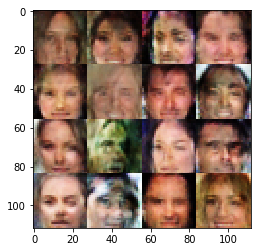

Epoch 0/1... Discriminator Loss: 0.8917... Generator Loss: 1.4072
Epoch 0/1... Discriminator Loss: 0.7245... Generator Loss: 1.3363
Epoch 0/1... Discriminator Loss: 1.0068... Generator Loss: 0.8199
Epoch 0/1... Discriminator Loss: 0.8764... Generator Loss: 0.9993
Epoch 0/1... Discriminator Loss: 0.8714... Generator Loss: 1.7775
Epoch 0/1... Discriminator Loss: 0.8220... Generator Loss: 1.3349
Epoch 0/1... Discriminator Loss: 0.9792... Generator Loss: 1.0601
Epoch 0/1... Discriminator Loss: 0.9801... Generator Loss: 1.1501
Epoch 0/1... Discriminator Loss: 0.8001... Generator Loss: 1.2669
Epoch 0/1... Discriminator Loss: 1.4440... Generator Loss: 0.6493


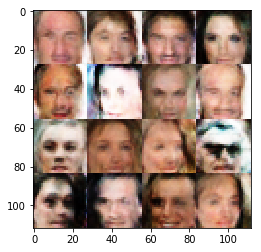

Epoch 0/1... Discriminator Loss: 0.8207... Generator Loss: 1.1233
Epoch 0/1... Discriminator Loss: 0.8274... Generator Loss: 1.1143
Epoch 0/1... Discriminator Loss: 0.9391... Generator Loss: 2.2384
Epoch 0/1... Discriminator Loss: 1.1927... Generator Loss: 0.7424
Epoch 0/1... Discriminator Loss: 0.8479... Generator Loss: 1.0870
Epoch 0/1... Discriminator Loss: 1.1780... Generator Loss: 2.0894
Epoch 0/1... Discriminator Loss: 1.1213... Generator Loss: 0.6646
Epoch 0/1... Discriminator Loss: 1.2282... Generator Loss: 0.5668
Epoch 0/1... Discriminator Loss: 0.8164... Generator Loss: 1.0974
Epoch 0/1... Discriminator Loss: 0.8170... Generator Loss: 1.0415


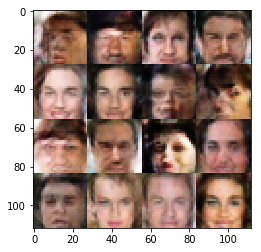

Epoch 0/1... Discriminator Loss: 0.9250... Generator Loss: 0.9533
Epoch 0/1... Discriminator Loss: 1.0351... Generator Loss: 1.2343
Epoch 0/1... Discriminator Loss: 1.4708... Generator Loss: 0.4861
Epoch 0/1... Discriminator Loss: 0.8614... Generator Loss: 1.2398
Epoch 0/1... Discriminator Loss: 1.0079... Generator Loss: 0.7901
Epoch 0/1... Discriminator Loss: 0.9674... Generator Loss: 0.7609
Epoch 0/1... Discriminator Loss: 1.0717... Generator Loss: 0.7548
Epoch 0/1... Discriminator Loss: 1.3243... Generator Loss: 1.5172
Epoch 0/1... Discriminator Loss: 0.7988... Generator Loss: 2.1225
Epoch 0/1... Discriminator Loss: 0.9106... Generator Loss: 0.9523


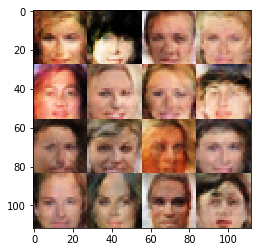

Epoch 0/1... Discriminator Loss: 0.8914... Generator Loss: 0.9932
Epoch 0/1... Discriminator Loss: 0.9515... Generator Loss: 0.8538
Epoch 0/1... Discriminator Loss: 1.3531... Generator Loss: 0.5510
Epoch 0/1... Discriminator Loss: 0.8391... Generator Loss: 1.7158
Epoch 0/1... Discriminator Loss: 0.8258... Generator Loss: 1.3945
Epoch 0/1... Discriminator Loss: 0.8765... Generator Loss: 0.8693
Epoch 0/1... Discriminator Loss: 0.9356... Generator Loss: 0.9194
Epoch 0/1... Discriminator Loss: 1.0063... Generator Loss: 1.0488
Epoch 0/1... Discriminator Loss: 1.1466... Generator Loss: 0.7994
Epoch 0/1... Discriminator Loss: 1.1188... Generator Loss: 0.7744


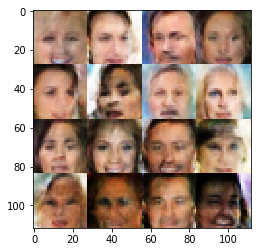

Epoch 0/1... Discriminator Loss: 0.7963... Generator Loss: 1.3240
Epoch 0/1... Discriminator Loss: 1.1547... Generator Loss: 0.6718
Epoch 0/1... Discriminator Loss: 1.1125... Generator Loss: 0.7362
Epoch 0/1... Discriminator Loss: 1.0093... Generator Loss: 1.7070
Epoch 0/1... Discriminator Loss: 0.9565... Generator Loss: 0.9745
Epoch 0/1... Discriminator Loss: 0.8023... Generator Loss: 1.3762
Epoch 0/1... Discriminator Loss: 1.1106... Generator Loss: 0.8659
Epoch 0/1... Discriminator Loss: 0.8914... Generator Loss: 1.3659
Epoch 0/1... Discriminator Loss: 0.8613... Generator Loss: 1.2222
Epoch 0/1... Discriminator Loss: 1.0551... Generator Loss: 0.7435


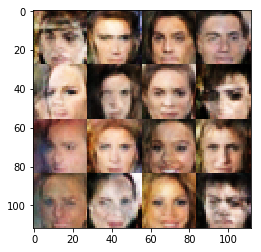

Epoch 0/1... Discriminator Loss: 0.8593... Generator Loss: 0.8630
Epoch 0/1... Discriminator Loss: 1.5020... Generator Loss: 0.4368
Epoch 0/1... Discriminator Loss: 0.7792... Generator Loss: 1.1774
Epoch 0/1... Discriminator Loss: 1.0646... Generator Loss: 0.7170
Epoch 0/1... Discriminator Loss: 1.2388... Generator Loss: 0.6394
Epoch 0/1... Discriminator Loss: 1.1999... Generator Loss: 0.6596
Epoch 0/1... Discriminator Loss: 1.4061... Generator Loss: 0.5903
Epoch 0/1... Discriminator Loss: 1.1899... Generator Loss: 0.7723
Epoch 0/1... Discriminator Loss: 0.7374... Generator Loss: 1.3711
Epoch 0/1... Discriminator Loss: 0.7513... Generator Loss: 1.4153


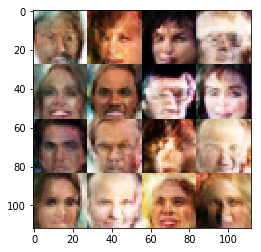

Epoch 0/1... Discriminator Loss: 0.7698... Generator Loss: 1.5741
Epoch 0/1... Discriminator Loss: 0.9805... Generator Loss: 0.8760
Epoch 0/1... Discriminator Loss: 0.9240... Generator Loss: 1.8045


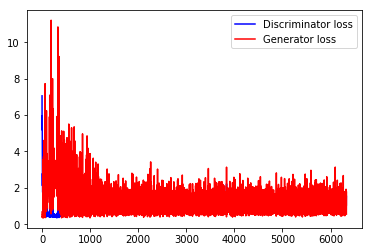

In [19]:
batch_size = 32 #32 delivered much better results than 128
z_dim = 60
learning_rate = 0.0002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.